## sigMF RF classification; 12 classes

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import glob
import json
from os import walk
import pickle
import json
import pathlib
import random
from timeit import default_timer as timer
import time
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
global GPU, fft, Fs, center_freq, fft_val, Fs_test, loss, batches, eps, var_noise, mean_noise, top
global c1_coeff, c2_coeff, a, r1_c1, r2_c1, r1_c2, r2_c2, compare
a = 1
compare = .5
r1_c2 = 1
r2_c2 = 100
top = .97
var_noise = 8.78e-09
# mean_noise = 10 # worked pretty good
mean_noise = 1
eps = 1e-15
Fs = 1000000
fft = 1024
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz
center_freq_live = 428.00e6 # when SDR doing 25MSPS with center at 428MHz
batches = 64
plt.style.use('default')
GPU = 0
device = torch.device('cuda:0')
print('Torch version =', torch.__version__, 'CUDA version =', torch.version.cuda)
print('CUDA Device:', device)
print('Is cuda available? =',torch.cuda.is_available())

Torch version = 1.6.0 CUDA version = 10.2
CUDA Device: cuda:0
Is cuda available? = True


In [2]:
!. /home/david/prefix-3.8/setup_env.sh

#### Machine paths; TRAINING, VALIDATION, AND SMALL TEST SETS

In [3]:
path_ram = "/home/david/sigMF_ML/RF/ramdisk/"
path_usrp = "/home/david/prefix-3.8/"
path = "/home/david/sigMF_ML/RF/RF_class/data/" # ACE
path_val1 = "/home/david/sigMF_ML/RF/RF_class/data_val1/" # fft_center    - class 9
path_val2 = "/home/david/sigMF_ML/RF/RF_class/data_val2/" # light switch - class 10
path_val3 = "/home/david/sigMF_ML/RF/RF_class/data_val3/" # clickndig     - class 5
path_val4 = "/home/david/sigMF_ML/RF/RF_class/data_val4/" # GD55          - class 1
path_val5 = "/home/david/sigMF_ML/RF/RF_class/data_val5/" # lora125       - class 0
path_val6 = "/home/david/sigMF_ML/RF/RF_class/data_val6/" # lora250       - class 7
path_val7 = "/home/david/sigMF_ML/RF/RF_class/data_val7/" # NFM           - class 2
path_val8 = "/home/david/sigMF_ML/RF/RF_class/data_val8/" # sado          - class 6
path_val9 = "/home/david/sigMF_ML/RF/RF_class/data_val9/" # TYT           - class 3
path_val10 = "/home/david/sigMF_ML/RF/RF_class/data_val10/" # vodeson     - class 4
path_val11 = "/home/david/sigMF_ML/RF/RF_class/data_val11/" # white noise - class 8
path_val12 = "/home/david/sigMF_ML/RF/RF_class/data_val12/" # ysf        - class 11
path_fig = "/home/david/sigMF_ML/RF/RF_class/" # ACE
path_val = "/home/david/sigMF_ML/RF/RF_class/testing_data/" # ACE
path_save = "/home/david/sigMF_ML/RF/RF_class/saved/" # ACE
path_test = "/home/david/sigMF_ML/RF/RF_class/testing_data/" # ACE
path_test_1msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/" # ACE
path_test_5msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_5msps/" # ACE
path_test_10msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_10msps/" # ACE
path_test_25msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_25msps/" # ACE
path_output2D = "/home/david/sigMF_ML/RF/RF_class/output_2D/"
path_output4D = "/home/david/sigMF_ML/RF/RF_class/output_4D/"
path_confuse = "/home/david/sigMF_ML/RF/RF_class/confuse/" # ACE
print(path)

/home/david/sigMF_ML/RF/RF_class/data/


In [4]:
# print(path_test)

# os.chdir(path_test)
# data_files_test = sorted(glob.glob('*.sigmf-data'))
# meta_files_test = sorted(glob.glob('*.sigmf-meta'))

Copyright (c) R. David Badger

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

## Functions 

In [39]:
# START OF FUNCTIONS ****************************************************
def meta_encoder(meta_list, num_classes): 
    a = np.asarray(meta_list, dtype=int)
#    print('a = ', a)
    return a 

def save_model():
    rf_model = 'ResNet50_v58_20210214_4D_10_autosave'
    PATH = path_save+rf_model
    torch.save(model.state_dict(), PATH)
    
# model = resnet50(4, 12) # number of input channels, number of classes
# model.load_state_dict
# CUDA = torch.cuda.is_available()
# if CUDA:
#     model.cuda(GPU)
# CUDA     

def load_model(rf_model):
    PATH = path_save+rf_model
    device = torch.device("cuda:0")
    model = resnet152(4, 12)
    model.load_state_dict(torch.load(PATH))
    model.to(device)
    model.eval()
    return model

def gpu_test_file(db,msps):
    if (msps == 1):
        w1 = fft*msps
    elif (msps == 5):
        w1 = fft*msps
    elif (msps == 10):
        w1 = fft*msps        
    elif (msps == 25):
        w1 = fft*msps 
#     print('gpu_test file function')    
    I = db[0::2]
    Q = db[1::2]
    w = fft*msps
#     print('Sample Rate = ',w,'MSPS')
    den = 2
#     print('window length = ', w1)
    win = torch.hann_window(w1, periodic=True, dtype=None, layout=torch.strided, requires_grad=False).cuda(GPU)
    I_stft = torch.stft(torch.tensor(I).cuda(GPU), n_fft=w, hop_length=w//den, win_length=w1, window=win, center=True, normalized=True, onesided=True)
    Q_stft = torch.stft(torch.tensor(Q).cuda(GPU), n_fft=w, hop_length=w//den, win_length=w1, window=win, center=True, normalized=True, onesided=True)
    X_stft = I_stft[...,0] + Q_stft[...,0] + I_stft[...,1] + -1*Q_stft[...,1]
#     print('X shape =', X_stft.shape)
#     print('I shape =', I_stft.shape, 'Q shape = ', Q_stft.shape )
    Z_stft = torch.cat((I_stft,Q_stft),2)
#     print('gpu_test Z shape =', Z_stft.shape)
    Z_stft = torch.cat((Z_stft[w//2:,:,:],Z_stft[:w//2,:,:])) # NOT SURE I NEED TO DO THIS...
    print('Final gpu_test file Z shape =', Z_stft.shape)
    Z_stft = Z_stft[:w//2,:,:] # throw bottom 1/2 away
    torch.cuda.empty_cache()
    return Z_stft # Returning 4D

def gpu_test_live(db,msps):
#     I = db[0:10000000:2]
#     Q = db[1:10000000:2]      
    print('gpu_test live function')    
    if (msps == 1):
        w1 = fft
    elif (msps == 5):
        w1 = fft*5
    elif (msps == 10):
        w1 = fft*10        
    elif (msps == 25):
        w1 = fft*25     
    I = db[0::2]
    Q = db[1::2]
    w = fft*msps
    print('Sample Rate = ',w,'MSPS')
    den = 2
    win = torch.hann_window(w1, periodic=True, dtype=None, layout=torch.strided, requires_grad=False).cuda(GPU)
    I_stft = torch.stft(torch.tensor(I).cuda(GPU), n_fft=w, hop_length=w//den, win_length=w1, window=win, center=True, normalized=True, onesided=True)
    Q_stft = torch.stft(torch.tensor(Q).cuda(GPU), n_fft=w, hop_length=w//den, win_length=w1, window=win, center=True, normalized=True, onesided=True)
    Z_stft = torch.cat((I_stft,Q_stft),2)
#     print('gpu_test live IQ shape =', Z_stft.shape)
    Z_stft = torch.cat((Z_stft[w//2:,:,:],Z_stft[:w//2,:,:])) # NOT SURE I NEED TO DO THIS...
    Z_stft = Z_stft[:w//2,:,:]# throw bottom 1/2 away
    print('FINAL gpu_test LIVE IQ shape =', Z_stft.shape)
    torch.cuda.empty_cache()
    return Z_stft # Returning 4D and plot

def iq_read(data_files): # USING GPU to perform STFT
    print('iq_read function**********')
    data_IQ_list = []
    data_IQ_temp = []
    for file in data_files:
        db = np.fromfile(file, dtype="float32")
#         stft = gpu(db).detach().cpu().numpy()
        print('iq_read function')
        stft, stft_plot = gpu_test_file(db)
        stft = stft.detach().cpu().numpy()
        stft_plot = stft_plot.detach().cpu().numpy()
        stft_plot = 10*np.log10(np.abs(stft_plot+eps))
        plt.imshow(stft_plot)
        plt.pcolormesh(stft_plot)
#         plt.imshow(stft, aspect='auto', origin='lower')
        plt.show()
        data_IQ_temp.append(stft)
    data_IQ_list = np.array(data_IQ_temp)
    return data_IQ_list

def iq_read_test_file(data_files,msps): # USING GPU to perform STFT
    data_IQ_list = []
    data_IQ_temp = []
    print('iq_read_test file')
    for file in data_files:
        db = np.fromfile(file, dtype="float32")
        stft = gpu_test_file(db,msps)
#         X_stft = stft[...,0] + stft[...,1] + stft[...,2] - stft[...,3]
#         stft_plot = 20*np.log10(np.abs(X_stft.detach().cpu().numpy()+eps))
#         print('imshow method')
#         plt.imshow(stft_plot, vmin=-70, vmax=5, aspect='auto', origin='lower')
#         plt.show()
        data_IQ_temp.append(stft.detach().cpu().numpy())
    data_IQ_list = np.array(data_IQ_temp)
    return data_IQ_list

def iq_read_test_live(data_files,msps): # USING GPU to perform STFT
#     iq_cpu_plot(data_files) #checking with cpu complex plotting
    data_IQ_list = []
    data_IQ_temp = []
    print('iq_read_test live: remarked out plotting')
    for file in data_files:
        db = np.fromfile(file, dtype="float32")
        stft = gpu_test_file(db,msps)
        # *************************************************************************
        X_stft = stft[...,0] + stft[...,1] + stft[...,2] - stft[...,3]
        stft_plot = 20*np.log10(np.abs(X_stft.detach().cpu().numpy()+eps))       
        print('iq_read_test live imshow method')
        plt.imshow(stft_plot, vmin=-70, vmax=5, aspect='auto', origin='lower')
        plt.show()
        # *************************************************************************
        data_IQ_temp.append(stft.detach().cpu().numpy())
    data_IQ_list = np.array(data_IQ_temp)
    return data_IQ_list

def read_meta(meta_files):
    meta_list = []
    for meta in meta_files:
        all_meta_data = json.load(open(meta))
        meta_list.append(all_meta_data['global']["core:class"])
    meta_list = list(map(int, meta_list))
    return meta_list

def read_num_val(x):
    x = len(meta_list_val)
    return x

#**************************** Print historgram subplots ******************************
def histo_plots(inputs):
    fig=plt.figure(figsize=(8,8))
    ncols = 2
    nrows = 2
    print('make torch inputs')
    print('inputs shape for histogram1 = ', inputs.shape)
    inputs = 10*np.log10(np.abs(inputs.cpu()+eps))
    for x in range(4):
#         print('x = ', x, 'inputs shape for histogram2 = ', inputs[:,:,x].shape)
        flat_inputs = torch.flatten(inputs[:,:,x], start_dim=0, end_dim=-1).numpy()
#         print('type = ', type(flat_inputs))
#         print('x = ', x, 'flat_input max = ', np.amax(flat_inputs))
#         print('inputs are: ', flat_inputs.shape)
        fig.add_subplot(nrows, ncols, x+1)
        plt.hist(flat_inputs, bins=5000)
        plt.gca().set(title='Frequency Histogram', ylabel='Frequency');
        plt.xlim(-100, 10)
#         plt.ylim(0, 40000)
    return flat_inputs
#*************************************************************************************    
#**************************** Print historgram subplots ******************************
def histo_stats(inputs):
#     print('make torch inputs')
#     print('inputs shape for histogram1 = ', inputs.shape)
    mean = np.zeros(4)
    std = np.zeros(4)
    for x in range(4):
#         print('x = ', x, 'inputs shape for histogram2 = ', inputs[:,:,x].shape)
        flat_inputs = torch.flatten(inputs[:,:,x], start_dim=0, end_dim=-1).numpy()
#         print('inputs are: ', flat_inputs.shape)
        mean[x] = flat_inputs.mean()
        std[x] = flat_inputs.std()
#         print('mean = ', mean, 'std = ', std)
    return mean, std
#**************************** Print historgram freq stats ******************************
def histo_stats_freq_file(inputs,msps):
    mean = inputs.mean()
    std = inputs.std()
    print("mean Freq = {0:9,.2f}".format(mean))
    print("std Freq = {0:9,.2f}".format(std))
    print('length of inputs = ', len(inputs))
#     plt.hist(inputs, 30, facecolor='blue', align='mid')
    if (msps==25):
        plt.hist(inputs, 30, range=[428.0, 440.0], facecolor='blue', align='mid')
    elif (msps==1):
        plt.hist(inputs, 30, range=[433.65, 434.15], facecolor='blue', align='mid')
    elif (msps==5):
        plt.hist(inputs, 30, range=[433.00, 435.50], facecolor='blue', align='mid')         
    elif (msps==10):
        plt.hist(inputs, 30, range=[433.00, 438.00], facecolor='blue', align='mid')        
    else:
        print('WRONG SAMPLE RATE CHOSEN')
    plt.gca().set(title='Frequency Histogram', ylabel='Frequency'); 
    plt.show()
def histo_stats_freq_live(inputs,msps):
    mean = inputs.mean()
    std = inputs.std()
    print("mean Freq = {0:9,.2f}".format(mean))
    print("std Freq = {0:9,.2f}".format(std))
    print('length of inputs = ', len(inputs))
#     plt.hist(inputs, 30, facecolor='blue', align='mid')
    if (msps==25):
        plt.hist(inputs, 30, range=[428.0, 440.0], facecolor='blue', align='mid')
    elif (msps==1):
        plt.hist(inputs, 30, range=[433.65, 434.15], facecolor='blue', align='mid')
    elif (msps==5):
        plt.hist(inputs, 30, range=[433.00, 435.50], facecolor='blue', align='mid')          
    elif (msps==10):
        plt.hist(inputs, 30, range=[433.00, 438.00], facecolor='blue', align='mid')         
    else:
        print('WRONG SAMPLE RATE CHOSEN')
    plt.gca().set(title='Frequency Histogram', ylabel='Frequency'); 
    plt.show()
# END OF FUNCTIONS ******************************************************

In [40]:
from functools import partial
from dataclasses import dataclass
from collections import OrderedDict

From scratch implementation of the famous ResNet models.
The intuition for ResNet is simple and clear, but to code
it didn't feel super clear at first, even when reading Pytorch own
implementation. 

Video explanation: 
Got any questions leave a comment on youtube :)

Programmed by Aladdin Persson <aladdin.persson at hotmail dot com>
*    2020-04-12 Initial coding

#### MIT License

SPECIFIC TO THE ResNet IMPLEMENTAION

Copyright (c) 2020 Aladdin Persson

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [41]:
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False) 

In [42]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels, self.out_channels =  in_channels, out_channels
        self.blocks = nn.Identity()
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

In [43]:
class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(OrderedDict(
        {
            'conv' : nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            'bn' : nn.BatchNorm2d(self.expanded_channels)
            
        })) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

In [44]:
def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(OrderedDict({'conv': conv(in_channels, out_channels, *args, **kwargs), 
                          'bn': nn.BatchNorm2d(out_channels) }))

In [45]:
class ResNetBasicBlock(ResNetResidualBlock):
    expansion = 1
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation(),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )

In [46]:
class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
             activation(),
             conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
             activation(),
             conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
        )

In [47]:
class ResNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x

In [48]:
class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by increasing different layers with increasing features.
    """
    def __init__(self, in_channels=3, blocks_sizes=[64, 128, 256, 512], deepths=[2,2,2,2], 
                 activation=nn.ReLU, block=ResNetBasicBlock, *args,**kwargs):
        super().__init__()
        
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=deepths[0], activation=activation, 
                        block=block,  *args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]       
        ])
        
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x

In [49]:
class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x

In [50]:
class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [51]:
def resnet18(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[2, 2, 2, 2])

def resnet34(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[3, 4, 6, 3])

def resnet50(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 6, 3])

def resnet101(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 23, 3])

def resnet152(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 8, 36, 3])

In [52]:
from torchsummary import summary

# model = resnet50(4, 12)
# summary(model.cuda(GPU), (4, 224, 224))

In [53]:
from torch.utils.data import Dataset

In [54]:
class RFDataset(Dataset):
    def __init__(self, root_path):
        print(root_path)
        self.root_path = root_path
        self.list_of_all_pickles = sorted(pathlib.Path(root_path).rglob('*/chopped-data-224-224/*.pickle'))
        self.get_class = dict()
        class_folders = list(pathlib.Path(root_path).glob('*/'))
        for class_folder in class_folders:
            class_index = -1
            metadata_path = list(class_folder.rglob('*.sigmf-meta'))[0]
            with open(metadata_path) as fp:
                metadata = json.load(fp)
                class_index = int(metadata["global"]["core:class"])
            self.get_class[str(class_folder.stem)] = class_index


    def __len__(self):
        return len(self.list_of_all_pickles)

    def __getitem__(self, idx):
        filepath = self.list_of_all_pickles[idx]
        with open(filepath, 'rb') as fp:
            tensor = pickle.load(fp)['bounded']
        foldername = filepath.parts[7]
        label = self.get_class[foldername]

        #return (tensor, label) # this is a tuple
        return {'data': tensor, 'label': label}

## Inference Segmented Dataloader

In [55]:
# Inference Dataloader with labels
class inference_dataloader_segmented_live(data.Dataset):
    def __init__(self):
        self.dataPath = path
        self.num_classes = 12
        self.num_examples = 1 # use only 1 for semi-live inferencing
    def __getitem__(self, index):
        sigmf_data = np.array(data_IQ_list_val[index]) 
        print('sigmf_data = ', sigmf_data.shape)
        frequency, time, dims1 = sigmf_data.shape
        print('frequency = ', frequency, '  time = ', time)
        data_IQ = []
        data_IQ_temp2 = []
        seg_t = 224  
        seg_f = 224 
        seg_time = time//seg_t
        seg_freq = frequency//seg_f
        print('seg_time = ', seg_time, 'seg_freq = ', seg_freq)
        # Segment the time axis
        for j in range(seg_time): 
                # Segment the frequency axis
                for k in range(seg_freq): 
                    IQ = sigmf_data[seg_f*k:(seg_f)+seg_f*k,seg_t*j:(seg_t)+seg_t*j]
                    data_IQ_temp2.append(IQ)            
        data_IQ = np.array(data_IQ_temp2)
        print('data_IQ shape = ', data_IQ.shape)
        loop_counter, dim1, dim2, dim3 = data_IQ.shape
        TRUTH =  meta_encoder(meta_list_val, self.num_classes)
        TRUTH = TRUTH.astype(np.float32)
        return torch.from_numpy(data_IQ),torch.from_numpy(TRUTH), loop_counter, seg_freq
    def __len__(self):
        return self.num_examples 

In [56]:
def inference_on_list_of_IQ_data(input_list):
    for sigmf_data in input_list:
        print('sigmf_data = ', sigmf_data.shape)
        frequency, time, dims1 = sigmf_data.shape
        print('frequency = ', frequency, '  time = ', time)
        data_IQ = []
        data_IQ_temp2 = []
        seg_t = 224  
        seg_f = 224 
        seg_time = time//seg_t
        seg_freq = frequency//seg_f
        print('seg_time = ', seg_time, 'seg_freq = ', seg_freq)
        # Segment the time axis
        for j in range(seg_time): 
                # Segment the frequency axis
                for k in range(seg_freq): 
                    IQ = sigmf_data[seg_f*k:(seg_f)+seg_f*k,seg_t*j:(seg_t)+seg_t*j]
                    data_IQ_temp2.append(IQ)            
        data_IQ = np.array(data_IQ_temp2)
        print('data_IQ shape = ', data_IQ.shape)
        loop_counter, dim1, dim2, dim3 = data_IQ.shape
        TRUTH =  meta_encoder(meta_list_val, self.num_classes)
        TRUTH = TRUTH.astype(np.float32)

In [57]:
# Inference Dataloader with labels
class inference_dataloader_segmented(data.Dataset):
    def __init__(self):
        self.dataPath = path
        self.num_classes = 12
        self.num_examples = 1 # uses a LOT of memory for more than 1 25MSPS STFT
    def __getitem__(self, index):
        sigmf_data = np.array(data_IQ_list_val[index]) 
        print('sigmf_data = ', sigmf_data.shape)
        frequency, time, dims1 = sigmf_data.shape
        print('frequency = ', frequency, '  time = ', time)
        data_IQ = []
        data_IQ_temp2 = []
        seg_t = 224  
        seg_f = 224 
        seg_time = time//seg_t
        seg_freq = frequency//seg_f
        print('seg_time = ', seg_time, 'seg_freq = ', seg_freq)
        # Segment the time axis
        for j in range(seg_time): 
                # Segment the frequency axis
                for k in range(seg_freq): 
                    IQ = sigmf_data[seg_f*k:(seg_f)+seg_f*k,seg_t*j:(seg_t)+seg_t*j]
                    data_IQ_temp2.append(IQ)            
        data_IQ = np.array(data_IQ_temp2)
        print('data_IQ shape = ', data_IQ.shape)
        loop_counter, dim1, dim2, dim3 = data_IQ.shape
        TRUTH =  meta_encoder(meta_list_val, self.num_classes)
        TRUTH = TRUTH.astype(np.float32)
        return torch.from_numpy(data_IQ),torch.from_numpy(TRUTH), loop_counter, seg_freq
    def __len__(self):
        return self.num_examples 

### validation functions

In [58]:
# def validation_read():    
#     # Inference DATA READING ************************************************
#     # read in validation IQ and meta data
#     os.chdir(path_val)
#     data_files_validation = sorted(glob.glob('*.sigmf-data'))
#     meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
#     for meta in meta_files_validation:
#         all_meta_data = json.load(open(meta))
#         print("validation file name = ", meta)
#     # Load validation sigmf-data files
#     meta_list_val = read_meta(meta_files_validation)
#     data_IQ_list_val = iq_read(data_files_validation)
#     return data_IQ_list_val, meta_list_val

In [59]:
# def testing_read():
#     print('testing_read function')
#     # Inference DATA READING ************************************************
#     # read in validation IQ and meta data
#     os.chdir(path_val)
#     data_files_validation = sorted(glob.glob('*.sigmf-data'))
#     meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
#     for meta in meta_files_validation:
#         all_meta_data = json.load(open(meta))
#         print("testing file name = ", meta)
#     meta_list_val = read_meta(meta_files_validation)
#     data_IQ_list_val = iq_read_test_file(data_files_validation)
#     return data_IQ_list_val, meta_list_val

## TEST directories

#### 1MSPS

In [60]:
path_test_1msps_lora125 = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/lora125/" # ACE
path_test_1msps_click = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/click/" # ACE
path_test_1msps_mix = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/mix/" # ACE
path_test_1msps_lora250 = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/lora250/" # ACE
path_test_1msps_gd55 = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/gd55/" # ACE
path_test_1msps_tyt = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/tyt/" # ACE
path_test_1msps_light = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/light" # ACE
path_test_1msps_vod = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/vod/" # ACE
path_test_1msps_sado = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/sado/" # ACE
path_test_1msps_nfm = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/nfm/" # ACE
path_test_1msps_ysf = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/ysf/" # ACE
path_test_1msps_noise = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/noise/" # ACE

In [61]:
path2_test_1msps_click = "/home/david/sigMF_ML/RF/testing_data_1msps_rev1/click/" # ACE
path2_test_1msps_vod = "/home/david/sigMF_ML/RF/testing_data_1msps_rev1/vod/" # ACE
path2_test_1msps_sado = "/home/david/sigMF_ML/RF/testing_data_1msps_rev1/sado/" # ACE

In [62]:
path_test_5msps_click = "/home/david/sigMF_ML/RF/RF_class/testing_data_5msps/click/" # ACE

#### 25MSPS

In [63]:
path_test_25msps_click = "/home/david/sigMF_ML/RF/25msps_test_b205/click/" # ACE
path_test_25msps_gd55 = "/home/david/sigMF_ML/RF/25msps_test_b205/gd55/" # ACE
path_test_25msps_light = "/home/david/sigMF_ML/RF/25msps_test_b205/light/" # ACE
path_test_25msps_lora125 = "/home/david/sigMF_ML/RF/25msps_test_b205/lora125/" # ACE
path_test_25msps_lora250 = "/home/david/sigMF_ML/RF/25msps_test_b205/lora250/" # ACE
path_test_25msps_noise = "/home/david/sigMF_ML/RF/25msps_test_b205/noise/" # ACE
path_test_25msps_vod = "/home/david/sigMF_ML/RF/25msps_test_b205/vod/" # ACE
path_test_25msps_sado = "/home/david/sigMF_ML/RF/25msps_test_b205/sado/" # ACE
path_test_25msps_uv5r = "/home/david/sigMF_ML/RF/25msps_test_b205/uv5r/" # ACE
path_test_25msps_vx8 = "/home/david/sigMF_ML/RF/25msps_test_b205/vx8/" # ACE
path_test_25msps_ysf = "/home/david/sigMF_ML/RF/25msps_test_b205/ysf/" # ACE
path_test_25msps_tyt = "/home/david/sigMF_ML/RF/25msps_test_b205/tyt/" # ACE
path_test_25msps_noise = "/home/david/sigMF_ML/RF/25msps_test_b205/noise/" # ACE

In [64]:
path2_test_25msps_click = "/home/david/sigMF_ML/RF/25msps_test/click/" # ACE
path2_test_25msps_gd55 = "/home/david/sigMF_ML/RF/25msps_test/gd55/" # ACE
path2_test_25msps_light = "/home/david/sigMF_ML/RF/25msps_test/light/" # ACE
path2_test_25msps_lora125 = "/home/david/sigMF_ML/RF/25msps_test/lora125/" # ACE
path2_test_25msps_lora250 = "/home/david/sigMF_ML/RF/25msps_test/lora250/" # ACE
path2_test_25msps_noise = "/home/david/sigMF_ML/RF/25msps_test/noise/" # ACE
path2_test_25msps_vod = "/home/david/sigMF_ML/RF/25msps_test/vod/" # ACE
path2_test_25msps_sado = "/home/david/sigMF_ML/RF/25msps_test/sado/" # ACE
path2_test_25msps_uv5r = "/home/david/sigMF_ML/RF/25msps_test/uv5r/" # ACE
path2_test_25msps_vx8 = "/home/david/sigMF_ML/RF/25msps_test/vx8/" # ACE
path2_test_25msps_ysf = "/home/david/sigMF_ML/RF/25msps_test/ysf/" # ACE
path2_test_25msps_tyt = "/home/david/sigMF_ML/RF/25msps_test/tyt/" # ACE
path2_test_25msps_noise = "/home/david/sigMF_ML/RF/25msps_test_b205/noise/" # ACE

In [65]:
def inference_read_testing(path,msps):    
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path) 
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("inference file name = ", meta)
    # Load validation sigmf-data files
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read_test_file(data_files_validation,msps)
    return data_IQ_list_val, meta_list_val

####  Not currently working: RF_test_Dataset

In [66]:
class RF_test_Dataset(Dataset):
    def __init__(self, root_path,msps):
        print(root_path)
#         print('Testing sample rate = ', msps)
        print('root_path = ', root_path)
        self.root_path = root_path
        self.list_of_all_data = sorted(pathlib.Path(root_path).rglob('*.sigmf-data'))
        self.list_of_all_meta = sorted(pathlib.Path(root_path).rglob('*.sigmf-meta'))

        
    def __len__(self):
        return len(self.list_of_all_data)

    def __getitem__(self, idx):
        iq_data_filepath = self.list_of_all_data[idx]
        meta_filepath = self.list_of_all_meta[idx]
        with open(meta_filepath) as fp:
            metadata = json.load(fp)
            print('fp = ', fp)
            class_index = int(metadata["global"]["core:class"])
#         self.get_class[str(class_folder.stem)] = class_index  
            print('class_index = ', class_index)
        iq_data = np.fromfile(iq_data_filepath, dtype="float32")
#         tensor = gpu_test_file(iq_data_filepath,msps)
              
        label = class_index
        
        #return (tensor, label) # this is a tuple
        return {'data': iq_data, 'label': label}

In [67]:
msps = 1
rf_test_dataset_lora125 = RF_test_Dataset(path_test_1msps_lora125,msps)
test_data_lora125 = data.DataLoader(rf_test_dataset_lora125, batch_size=1, shuffle=True)

/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/lora125/
root_path =  /home/david/sigMF_ML/RF/RF_class/testing_data_1msps/lora125/


In [68]:
def inference_read(msps):    
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path_ram) 
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("inference file name = ", meta)
    # Load validation sigmf-data files
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read_test_file(data_files_validation,msps)
    return data_IQ_list_val, meta_list_val

In [69]:
def inference_read_file(msps,path):    
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path)
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("inference file name = ", meta)
    # Load validation sigmf-data files
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read_test_file(data_files_validation,msps)
    return data_IQ_list_val, meta_list_val

In [70]:
def score_IQ_data_files(center_freq_file, list_of_IQ_data, list_of_labels,load_net):    
    with torch.no_grad():
        model = load_model(load_net)
        total = noise = center_fft = target_to_int = accumulated_corrects = percent_correct = 0
        histogram_global = {}
        histogram_data = np.zeros((10,10))
        h = 0
        for data in list_of_IQ_data:
            print('data shape = ', data.shape)
            data = data[9:,:,:]
            histogram = np.zeros(12)
            # chop "data" into the required patch size
            frequency, time, dims1 = data.shape
            print('freq bins= ', frequency)
            list_of_patches = []
            seg_t = 224  
            seg_f = 224 
            seg_time = time//seg_t
            seg_freq = frequency//seg_f
            # Segment the time axis
            for j in range(seg_time): 
                    # Segment the frequency axis
                    for k in range(seg_freq): 
                        IQ = data[seg_f*k:(seg_f)+seg_f*k,seg_t*j:(seg_t)+seg_t*j]
                        list_of_patches.append(IQ)   
#***************************************************************************************************************                        
            start_frequency = (center_freq_file)
            match_freq = start_frequency   
            print('start_frequency = ', start_frequency/1000000)           
            # loop through each square  in list_of_patches and score each
            freq_increment = (Fs*msps/2)/seg_freq
            histogram_frequency = np.zeros(len(list_of_patches))
            denom = len(list_of_patches)
            print('patch total = ', denom)
            count_noise = 0
            count_center = 0
            freq_histo = np.zeros(len(list_of_patches))
            freq_count = 0 # keep track of array position
            freq_offset = 0
            for (j, patch) in enumerate(list_of_patches):
                num_correct, accuracy = 0, 0
# #**************************** Print segmented pics ***********************************
#                 stft_plot = patch
#                 fig=plt.figure(figsize=(8,8))
#                 if (j<2):
#                         stft_plot1 =  10*np.log10(np.abs(stft_plot[...,0] + stft_plot[...,1] + stft_plot[...,2] + -1*stft_plot[...,3]+eps))
#                         plt.imshow(stft_plot1, vmin=-70, vmax=5)
#                         plt.show()
# #*************************************************************************************                
                patch = torch.Tensor(patch) # convert path to tensor
                patch = patch.unsqueeze(0) # give the patch a fake batch axis
                patch = patch.permute(0,3,1,2) # move the channel axis to the front
                patch = patch.contiguous().cuda(GPU) # move the tensor to GPU     
                outputs = model(patch)
                predicted_class = int(torch.argmax(outputs.data))
                histogram[predicted_class] += 1
                histogram_global[predicted_class] = histogram_global.get(predicted_class, 0) + 1
                if predicted_class == 8:
                    count_noise += 1
                if predicted_class == 9:
                    count_center += 1
                match_freq = match_freq + freq_offset*freq_increment
#*******************************************************************************   
                if (predicted_class == 0):
                    freq_histo[j] = match_freq/1000000
                if (predicted_class == 1):
                    freq_histo[j] = match_freq/1000000
                if (predicted_class == 2):
                    freq_histo[j] = match_freq/1000000
                if (predicted_class == 3):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 4):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 5):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 6):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 7):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 10):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 11):
                    freq_histo[j] = match_freq/1000000                   
#******************************************************************************
                histogram_frequency[j] = match_freq/1000000
                freq_offset = freq_offset + 1
                if (freq_offset == seg_freq):
                    freq_offset = 0
                match_freq = start_frequency                
            # print statistics
            denom = denom - count_noise - count_center
            histo_stats_freq_file(freq_histo, msps)
            print('************************* Probabilities ********************************')
            print('----------------------------WAVEFORMS-----------------------------------')
            if (denom == 0):
                print('Nothing but noise')
            else:
                print('LoRa 125 = {:.2f}%'.format(histogram[0]/denom))
                print('GD55 DMR = {:.2f}%'.format(histogram[1]/denom))
                print('NFM = {:.2f}%'.format(histogram[2]/denom))
                print('TYT = {:.2f}'.format(histogram[3]/denom))
                print('Vodeson Doorbell = {:.2f}%'.format(histogram[4]/denom))
                print('clickndig = {:.2f}%'.format(histogram[5]/denom))
                print('Sado doorbell = {:.2f}%'.format(histogram[6]/denom))
                print('LoRa 250 = {:.2f}%'.format(histogram[7]/denom))
                print('light switch = {:.2f}%'.format(histogram[10]/denom))
                print('YSF = {:.2f}%'.format(histogram[11]/denom))
            print('------------------------------------------------------------------------')
            print('***************************** noise and fft ****************************')
            print('noise matches = ', count_noise)
            print('center fft matches = ', count_center)
            print('TOTAL patch count = ', len(list_of_patches))
            print('***************************** Finished *********************************')
            histogram_data[h,0] = histogram[0]/denom
            histogram_data[h,1] = histogram[1]/denom
            histogram_data[h,2] = histogram[2]/denom
            histogram_data[h,3] = histogram[3]/denom
            histogram_data[h,4] = histogram[4]/denom
            histogram_data[h,5] = histogram[5]/denom
            histogram_data[h,6] = histogram[6]/denom
            histogram_data[h,7] = histogram[7]/denom
            histogram_data[h,8] = histogram[10]/denom   
            histogram_data[h,9] = histogram[11]/denom                       
            h = h + 1
    return histogram_global, histogram_data

In [71]:
#     # inference ************************************************************
# def testing_file(msps):    
#         large_width = 400
#         np.set_printoptions(precision=2,floatmode='fixed', linewidth=large_width)
#         model = load_model('ResNet50_v58_20210212_4D_100')
#         V = data.DataLoader(inference_dataloader_segmented(), batch_size=1)
#         start_frequency = (center_freq_file)
#         match_freq = start_frequency
#         print('start_frequency = ', start_frequency/1000000)
#         freq_offset = 0       
#         total = noise = center_fft = target_to_int = accumulated_corrects = percent_correct = 0
#         c0 = c1 = c2 = c3 = c4 = c5 = c6 = c7 = c8 = c9 = 0
# #         total = 68
#         with torch.no_grad():
#             for i, rf_data in enumerate(V, 0):   
#                 accumulated_corrects = 0
#                 percent_correct = 0
#                 target_to_int = 0
#                 inputs, target, counter, seg_freq = rf_data 
#                 print('testing counter = ', counter, 'seg_freq =', seg_freq)
# #**************************** Print segmented pics ***********************************
# #                 stft_plot = np.squeeze(inputs, axis=0)
# #                 fig=plt.figure(figsize=(8,8))
# #                 ncols = 5
# #                 nrows = 5
# #                 range_plot = 1
# #                 for x in range(1,22): # need to figure out how to not hard code this
# #                     stft_mean, stft_std = histo_stats(stft_plot[x,:,:,:])
# #                     if (x>=range_plot and x<(range_plot+25)):
# #                         stft_plot1 =  10*np.log10(np.abs(stft_plot[x, :, :, 0]+eps))
# #                         stft_plot1 = np.squeeze(stft_plot1, axis=0)
# #                         fig.add_subplot(nrows, ncols, x-range_plot+1)
# #                         plt.imshow(stft_plot1, vmin=-70, vmax=5)
# #                 plt.show()
# #*************************************************************************************
#                 freq_increment = (Fs*msps/2)/seg_freq.detach().cpu().numpy().item()
#                 print('freq_increment = ', freq_increment)
#                 print('TESTING inputs SHAPE = ', inputs.shape)
#                 target = Variable(target.cuda(GPU)) 
# #                 print('input in   = ', inputs.shape)
#                 inputs = torch.squeeze(inputs, dim=0)
# #                 print('input out  = ', inputs.shape)
#                 inputs = inputs.permute(0,3,1,2).contiguous()
# #                 print('counter convert stuff = ', counter, type(counter.numpy()))
#                 inputs = Variable(inputs.cuda(GPU))
# #                 print('permuted shape = ', inputs.shape)
#                 freq_count = 0 # keep track of array position
#                 freq_histo = np.zeros(counter.numpy())
#                 for j in range(counter):
#                     inputs2 = inputs[j,:,:,:]
#                     inputs2 = torch.unsqueeze(inputs2,0)
#                     outputs = model(inputs2)
#                     _, predicted = torch.max(outputs.data, 1) 
# #******************************* Print prediction range to match pics above ***********        
# #                     if (j>=range_plot and j<(range_plot+25)):                    
# #                         print("j= ",j,' ',outputs.data.detach().cpu().numpy())
# #                         print('prediction = ', predicted.detach().cpu().numpy())
# #*************************************************************************************               
#                     total = total +1  # Increment the total count
#                     match_freq = match_freq + freq_offset*freq_increment
#                     if (predicted.detach().cpu().numpy() == 0):
#                         c0 = c0 + 1  
#                         freq_histo[j] = match_freq/1000000
#                     if (predicted.detach().cpu().numpy() == 1):
#                         c1 = c1 + 1
#                         freq_histo[j] = match_freq/1000000
#                     if (predicted.detach().cpu().numpy() == 2):
#                         c2 = c2 + 1
#                         freq_histo[j] = match_freq/1000000
#                     if (predicted.detach().cpu().numpy() == 3):
#                         c3 = c3 + 1
#                         freq_histo[j] = match_freq/1000000            
#                     if (predicted.detach().cpu().numpy() == 4):
#                         c4 = c4 + 1
#                         freq_histo[j] = match_freq/1000000            
#                     if (predicted.detach().cpu().numpy() == 5):
#                         c5 = c5 + 1 
#                         freq_histo[j] = match_freq/1000000            
#                     if (predicted.detach().cpu().numpy() == 6):
#                         c6 = c6 + 1 
#                         freq_histo[j] = match_freq/1000000            
#                     if (predicted.detach().cpu().numpy() == 7):
#                         c7 = c7 + 1 
#                         freq_histo[j] = match_freq/1000000            
#                     if (predicted.detach().cpu().numpy() == 8):
#                         noise = noise + 1
#                     if (predicted.detach().cpu().numpy() == 9):
#                         center_fft = center_fft + 1  
#                     if (predicted.detach().cpu().numpy() == 10):
#                         c8 = c8 + 1  
#                         freq_histo[j] = match_freq/1000000            
#                     if (predicted.detach().cpu().numpy() == 11):
#                         c9 = c9 + 1 
#                         freq_histo[j] = match_freq/1000000            
#                     freq_offset = freq_offset + 1
#                     if (freq_offset == seg_freq):
#                         freq_offset = 0
#                     match_freq = start_frequency
#                 torch.cuda.empty_cache()
#                 # complete ******************************************************
#                 freq_histo = np.ma.masked_equal(freq_histo, 0)
#                 histo_stats_freq_file(freq_histo,msps)
#                 denom = total-center_fft-noise
#                 print('************************* Probabilities ********************************')
#                 print('----------------------------WAVEFORMS-----------------------------------')
#                 if (denom == 0):
#                     print('Nothing but noise')
#                 else:
#                     print('LoRa 125 = {:.2f}%'.format(c0/denom*100))
#                     print('GD55 DMR = {:.2f}%'.format(c1/denom*100))
#                     print('NFM = {:.2f}%'.format(c2/denom*100))
#                     print('TYT = {:.2f}'.format(c3/denom*100))
#                     print('Vodeson Doorbell = {:.2f}%'.format(c4/denom*100))
#                     print('clickndig = {:.2f}%'.format(c5/denom*100))
#                     print('Sado doorbell = {:.2f}%'.format(c6/denom*100))
#                     print('LoRa 250 = {:.2f}%'.format(c7/denom*100))
#                     print('light switch = {:.2f}%'.format(c8/denom*100))
#                     print('YSF = {:.2f}%'.format(c9/denom*100))
#                 print('------------------------------------------------------------------------')
#                 print('***************************** noise and fft ****************************')
#                 print('noise matches = ', noise)
#                 print('center fft matches = ', center_fft)
#                 print('TOTAL patch count = ', total)
#                 print('***************************** Finished *********************************')

In [72]:
    # inference ************************************************************
def testing_live(msps):    
        large_width = 400
        np.set_printoptions(precision=2,floatmode='fixed', linewidth=large_width)
        model.eval()
        V = data.DataLoader(inference_dataloader_segmented_live(), batch_size=1)
        start_frequency = (center_freq_live)
        match_freq = start_frequency
        print('start_frequency = ', start_frequency/1000000)
        freq_offset = 0       
        total = noise = center_fft = target_to_int = accumulated_corrects = percent_correct = 0
        c0 = c1 = c2 = c3 = c4 = c5 = c6 = c7 = c8 = c9 = 0
        with torch.no_grad():
            for i, rf_data in enumerate(V, 0):   
                accumulated_corrects = 0
                percent_correct = 0
                target_to_int = 0
                inputs, target, counter, seg_freq = rf_data 
                print('testing counter = ', counter, 'seg_freq =', seg_freq)
                print('seg_freq = ', seg_freq)
#**************************** Print segmented pics ***********************************
                stft_plot = np.squeeze(inputs, axis=0)
                fig=plt.figure(figsize=(8,8))
                ncols = 5
                nrows = 5
                range_plot = 1
                range_end = range_plot+5
                for x in range(1,51): # need to figure out how to not hard code this ********************* <-----
                    if (x>=range_plot and x<(range_end)):
                        stft_plot1 =  10*np.log10(np.abs(stft_plot[x, :, :, 0]+eps))
                        stft_plot1 = np.squeeze(stft_plot1, axis=0)
                        fig.add_subplot(nrows, ncols, x-range_plot+1)
                        plt.imshow(stft_plot1, vmin=-70, vmax=5)
                plt.show()
#******************************************************************************************    
                freq_increment = (Fs*msps/2)/seg_freq.detach().cpu().numpy().item()
                print('freq_increment = ', freq_increment)
                print('TESTING inputs SHAPE = ', inputs.shape)
                target = Variable(target.cuda(GPU)) 
                print('input in   = ', inputs.shape)
                inputs = torch.squeeze(inputs, dim=0)
                print('input out  = ', inputs.shape)
                inputs = inputs.permute(0,3,1,2).contiguous()
                print('counter convert stuff = ', counter, type(counter.numpy()))
                inputs = Variable(inputs.cuda(GPU))
                print('permuted shape = ', inputs.shape)
                freq_count = 0 # keep track of array position
                freq_histo = np.zeros(counter.numpy())
                for j in range(counter):
                    inputs2 = inputs[j,:,:,:]
                    inputs2 = torch.unsqueeze(inputs2,0)
                    outputs = model(inputs2)
                    _, predicted = torch.max(outputs.data, 1) 
#******************************* Print prediction range to match pics above ***********        
#                     if (j>=range_plot and j<(range_end)):                    
#                         print("j= ",j,' ',outputs.data.detach().cpu().numpy())
#                         print('prediction = ', predicted.detach().cpu().numpy())
#                         print('******************')                
#*************************************************************************************               
                    total = total +1  # Increment the total count
                    match_freq = match_freq + freq_offset*freq_increment
                    if (predicted.detach().cpu().numpy() == 0):
                        c0 = c0 + 1  
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 1):
                        c1 = c1 + 1
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 2):
                        c2 = c2 + 1
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 3):
                        c3 = c3 + 1
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 4):
                        c4 = c4 + 1
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 5):
                        c5 = c5 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 6):
                        c6 = c6 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 7):
                        c7 = c7 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 8):
                        noise = noise + 1
                    if (predicted.detach().cpu().numpy() == 9):
                        center_fft = center_fft + 1  
                    if (predicted.detach().cpu().numpy() == 10):
                        c8 = c8 + 1  
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 11):
                        c9 = c9 + 1 
                        freq_histo[j] = match_freq/1000000            
                    freq_offset = freq_offset + 1
                    if (freq_offset == seg_freq):
                        freq_offset = 0
                    match_freq = start_frequency
                torch.cuda.empty_cache()
                # complete ******************************************************
                freq_histo = np.ma.masked_equal(freq_histo, 0)
                histo_stats_freq_live(freq_histo,msps)
                denom = total-center_fft-noise
                print('************************* Probabilities ********************************')
                print('----------------------------WAVEFORMS-----------------------------------')
                if (denom == 0):
                    print('Nothing but noise')
                else:
                    print('LoRa 125 = {:.2f}%'.format(c0/denom*100))
                    print('GD55 DMR = {:.2f}%'.format(c1/denom*100))
                    print('NFM = {:.2f}%'.format(c2/denom*100))
                    print('TYT = {:.2f}'.format(c3/denom*100))
                    print('Vodeson Doorbell = {:.2f}%'.format(c4/denom*100))
                    print('clickndig = {:.2f}%'.format(c5/denom*100))
                    print('Sado doorbell = {:.2f}%'.format(c6/denom*100))
                    print('LoRa 250 = {:.2f}%'.format(c7/denom*100))
                    print('light switch = {:.2f}%'.format(c8/denom*100))
                    print('YSF = {:.2f}%'.format(c9/denom*100))
                print('------------------------------------------------------------------------')
                print('***************************** noise and fft ****************************')
                print('noise matches = ', noise)
                print('center fft matches = ', center_fft)
                print('TOTAL patch count = ', total)
                print('***************************** Finished *********************************')

## CUDA initialization

In [73]:
# model = resnet50(4, 12) # number of input channels, number of classes
# model.load_state_dict
# CUDA = torch.cuda.is_available()
# if CUDA:
#     model.cuda(GPU)
# CUDA  

In [74]:
torch.cuda.empty_cache()

#### PLOTTING CODE

In [41]:
# path_plot_fig = "/home/david/sigMF_ML/RF/RF_class/plot_data/" # ACE
# os.chdir(path_plot_fig)
# # num = 20
# np.save('vgg16_2D_plot_10dB_vals', np.asarray(total_plot))
# np.save('vgg16_2D_plot_10dB_vals_2', total_plot) 

In [42]:
# os.chdir(path_plot_fig)
# resnet50_2D = np.load('resnet50_2D_plot_10dB_vals.npy')
# resnet50_4D = np.load('resnet50_4D_plot_100vals_rev1.npy')
# resnet18_4D = np.load('resnet18_4D_plot_100vals.npy')
# resnet18_2D = np.load('resnet18_2D_plot_10dB_new.npy')
# vgg16_4D = np.load('VGG16_4D_plot_100vals.npy')
# vgg16_2D = np.load('vgg16_2D_plot_10dB_vals.npy')

In [43]:
# # num = len(resnet50_4D) # reduced rank by 1 for matrix math to work out
# ymin = 80
# ymax = 100
# num = 300
# x = np.arange(0,num,1) # Start at index position 1
# plt.figure(figsize=(9, 6))
# fig2 = plt.figure()
# plt.plot(x[0:num],resnet18_4D[:num], c='#1f77b4',markersize=1, linewidth=1,markerfacecolor='#1f77b4',markeredgecolor='#1f77b4',markeredgewidth=2,label='ResNet18 4D')
# plt.plot(x[1:num],resnet18_2D[1:num], c='#ff7f0e',markersize=1, linewidth=2,markerfacecolor='#ff7f0e',markeredgecolor='#ff7f0e',markeredgewidth=2, label='ResNet18 2D')
# plt.plot(x[1:num],vgg16_4D[1:num], c='#2ca02c', markersize=1, linewidth=1,markerfacecolor='#2ca02c',markeredgecolor='#2ca02c',markeredgewidth=2, label='VGG16 4D')
# plt.plot(x[1:num],resnet50_2D[1:num], c='#d62728', markersize=1, linewidth=1,markerfacecolor='#d62728',markeredgecolor='#d62728',markeredgewidth=2, label='ResNet50 2D')
# plt.plot(x[1:num],resnet50_4D[1:num], c='#9467bd', markersize=1, linewidth=1,markerfacecolor='#9467bd',markeredgecolor='#9467bd',markeredgewidth=2, label='ResNet50 4D')
# plt.plot(x[1:num],vgg16_2D[1:num], c='#8c564b', markersize=1, linewidth=1,markerfacecolor='#8c564b',markeredgecolor='#8c564b',markeredgewidth=2, label='VGG16 2D')
# plt.legend(loc='lower right')
# axes = plt.gca()
# # axes.set_xlim([xmin,xmax])
# axes.set_ylim([ymin,ymax])
# #  '-o'   '-X' '-P' '-D' '-^' '-*'
# plt.title('Validation accuracy')
# plt.xlabel('Iteration')
# plt.ylabel('% accuracy')
# plt.grid()
# # plt.minorticks_on()
# plt.yticks(np.arange(80,101, 10))
# plt.xticks([0, 25, 50, 100, 120])
# fig2.savefig('all_network_plots.pdf', format="pdf")
# plt.show()

#### Testing from saved recording data

### LIVE inferencing

###  TESTING

In [44]:
# # rf_model = 'ResNet50_v58_20210214_4D_150_93percent'
# # rf_model = 'ResNet50_v58_20210213_4D_20dB_autosave' # jacked up
# # rf_model = 'ResNet50_v58_20210212_4D_100'
# rf_model = 'ResNet50_v56_20210208_4D_20dB_autosave'
# PATH = path_save+rf_model
# device = torch.device("cuda:1")
# model.load_state_dict(torch.load(PATH))
# model.to(device)
# model.eval()
# msps = 1
# center_freq_live = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# !python3 /home/david/sigMF_ML/gnuradio/record_live_1msps.py
# data_IQ_list_val, meta_list_val = inference_read(msps)
# testing_live(msps)
# torch.cuda.empty_cache()

In [125]:
# msps = 5
# center_freq_live = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# !python3 /home/david/sigMF_ML/gnuradio/record_live_5msps.py
# # !python3 /home/david/sigMF_ML/gnuradio/record_live1msps.py
# # usrp_data_collect_1MSPS()
# data_IQ_list_val, meta_list_val = inference_read(msps)
# testing_live(msps)
# torch.cuda.empty_cache()

In [126]:
# msps = 1
# center_freq_live = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# # !python3 /home/david/sigMF_ML/gnuradio/record_live25msps.py
# !python3 /home/david/sigMF_ML/gnuradio/record_live_1msps.py
# # usrp_data_collect_1MSPS()
# data_IQ_list_val, meta_list_val = inference_read(msps)
# testing_live(msps)
# torch.cuda.empty_cache()

# msps = 1
# center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
# data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps_click)
# score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
# torch.cuda.empty_cache()

In [127]:
torch.cuda.empty_cache()

## testing pre-recorded files in /home/david/sigMF_ML/RF/RF_class/testing_data

In [128]:
# msps = 5
# center_freq_file = 433.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_5msps)
# testing_file(msps)
# torch.cuda.empty_cache()

In [129]:
# msps = 25
# center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_25msps)
# testing_file(msps)
# torch.cuda.empty_cache()

In [130]:
# msps = 1
# center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps)
# testing_file(msps)
# torch.cuda.empty_cache()

In [131]:
# msps = 1
# center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps)
# testing_file(msps)
# torch.cuda.empty_cache()

#### plotting code

In [151]:
path_plot_fig = "/home/david/sigMF_ML/RF/RF_class/plot_data/" # ACE
os.chdir(path_plot_fig)
# resnet18_adadelta = np.load('resnet18_4D_adadelta_20210305.npy')
# resnet18_adagrad = np.load('resnet18_4D_1e4_20210305_adgrad.npy')
# resnet18_5e6 = np.load('resnet18_4D_5e6_20210305.npy')
# resnet18_10e6 = np.load('resnet18_4D_1e5_20210305.npy')
# resnet18_100e6 = np.load('resnet18_4D_plot_20210305_1e3.npy')
# resnet18_500e6 = np.load('resnet18_4D_plot_20210305_5e4.npy')
# resnet18_4D_adamax = np.load('resnet18_4D_plot_1e4_adamax.npy')

#***************** AdamW ***********************************************
resnet18_4D_adamaw = np.load('resnet18_4D_plot_adamw.npy')
resnet18_2D_adamaw = np.load('resnet18_2D_plot_20210307_adamw.npy')
resnet50_4D_adamaw = np.load('resnet50_4D_AdamW.npy')
resnet50_2D_adamaw = np.load('resnet50_2D_202100308_adamw.npy')
#***************** AdamW **************************************************
vgg16_4D_adamw = np.load('VGG16_4D_plot_20210308_adamw.npy')
vgg16_2D_adamw = np.load('vgg16_2D_plot_adamw.npy')

resnet152_4CH = np.load('resnet152_4D_AdamW.npy')
#***********************************************************************
vgg16_4D = np.load('vgg16_2D_plot_10dB_20210227.npy')
vgg16_2D = np.load('VGG16_4D_plot_20210226.npy')
vgg16_2CH_1e5 = np.load('vgg16_2D_plot_1e5.npy')
resnet18_2CH_1e5 = np.load('resnet18_2D_plot_20210309_1e5.npy')
vgg16_4D_1e5 = np.load('vgg16_4D_plot_1e5.npy')
resnet50_2CH_1e5 = np.load('resnet50_2D_202100309_adamw_1e5.npy')

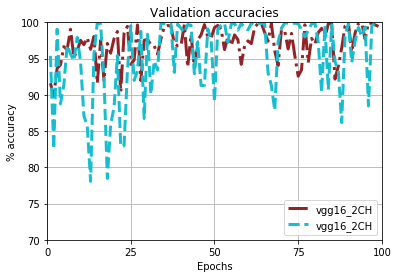

In [153]:
ymin = 70
ymax = 100
num = 100
lw = 3
x = np.arange(0,num,1) # Start at index position 1
plt.figure(figsize=(9, 6))
fig2 = plt.figure()
# plt.plot(x[1:num],resnet18_adadelta[1:num], c='#1f77b4',markersize=1, linewidth=lw,markerfacecolor='#1f77b4',markeredgecolor='#1f77b4',markeredgewidth=1,label='adadelta')
# plt.plot(x[1:num],resnet18_adagrad[1:num], c='#ff7f0e',markersize=1, linewidth=lw,markerfacecolor='#ff7f0e',markeredgecolor='#ff7f0e',markeredgewidth=1, label='adagrad')
# plt.plot(x[1:num],resnet18_5e6[1:num], c='#2ca02c', markersize=1, linewidth=lw,markerfacecolor='#2ca02c',markeredgecolor='#2ca02c',markeredgewidth=1, label='5e-6')
# plt.plot(x[1:num],resnet18_10e6[1:num], c='#d62728', markersize=1, linewidth=lw,markerfacecolor='#d62728',markeredgecolor='#d62728',markeredgewidth=1, label='10e-6')
# plt.plot(x[1:num],resnet18_100e6[1:num], c='#9467bd', markersize=1, linewidth=lw,markerfacecolor='#9467bd',markeredgecolor='#9467bd',markeredgewidth=1, label='100e-6')
# plt.plot(x[1:num],resnet18_500e6[1:num], c='#8c564b', markersize=1, linewidth=lw,markerfacecolor='#8c564b',markeredgecolor='#8c564b',markeredgewidth=2, label='500e-6')
#***************** AdamW ***********************************************
# plt.plot(x[1:num],resnet18_4D_adamaw[1:num], c='#1f77b4',markersize=1, linewidth=lw,markerfacecolor='#1f77b4',markeredgecolor='#1f77b4',markeredgewidth=1,label='resnet18_4CH')
# plt.plot(x[1:num],resnet18_2D_adamaw[1:num], c='#ff7f0e',markersize=1, linewidth=lw,markerfacecolor='#ff7f0e',markeredgecolor='#ff7f0e',markeredgewidth=1, label='resnet18_2CH')
# plt.plot(x[1:num],resnet18_2CH_1e5[1:num], c='#cc2529', markersize=1, linewidth=lw,markerfacecolor='#cc2529',markeredgecolor='#2ca02c',markeredgewidth=1, label='resnet18_2CH 1e-5')
# plt.plot(x[1:num],resnet50_4D_adamaw[1:num], c='#2ca02c', markersize=1, linewidth=lw,markerfacecolor='#2ca02c',markeredgecolor='#2ca02c',markeredgewidth=1, label='resnet50_4CH')
# plt.plot(x[1:num],resnet50_2D_adamaw[1:num], c='#d62728', markersize=1, linewidth=lw,markerfacecolor='#d62728',markeredgecolor='#d62728',markeredgewidth=1, label='resnet50_2CH')
# plt.plot(x[1:num],vgg16_4D[1:num], c='#9467bd', markersize=1, linewidth=lw,markerfacecolor='#9467bd',markeredgecolor='#9467bd',markeredgewidth=1, label='vgg16_4CH')
# plt.plot(x[1:num],vgg16_4D_1e5[1:num], c='#8c564b', markersize=1, linewidth=lw,markerfacecolor='#8c564b',markeredgecolor='#8c564b',markeredgewidth=2, label='vgg16_4CH 1e-5')
# plt.plot(x[1:num],vgg16_2D[1:num], c='#396ab1', markersize=1, linewidth=lw,markerfacecolor='#396ab1',markeredgecolor='#8c564b',markeredgewidth=2, label='vgg16_2CH')
# plt.plot(x[1:num],vgg16_2D[1:num], c='#922428', markersize=1, linewidth=lw,markerfacecolor='#922428',markeredgecolor='#8c564b',markeredgewidth=2, label='vgg16_2CH')
#***************** AdamW ***********************************************
# plt.plot(x[1:num],resnet152_4CH[1:num], c='#8c564b', markersize=1, linewidth=lw,markerfacecolor='#8c564b',markeredgecolor='#8c564b',markeredgewidth=2, label='ResNet152_4CH')



#**************************************************************************************************************
# plt.plot(x[1:num],vgg16_4D_1e5[1:num], c='#8c564b', markersize=1, linewidth=lw,markerfacecolor='#8c564b',markeredgecolor='#8c564b',markeredgewidth=2, label='vgg16_4CH 1e-5')
plt.plot(x[1:num],vgg16_2D[1:num], c='#922428', markersize=1,linestyle='-.',linewidth=lw,markerfacecolor='#922428',markeredgecolor='#8c564b',markeredgewidth=2, label='vgg16_2CH')
plt.plot(x[1:num],vgg16_2CH_1e5[1:num], c='tab:cyan', markersize=1,linestyle='--',linewidth=lw,markerfacecolor='#922428',markeredgecolor='#8c564b',markeredgewidth=2, label='vgg16_2CH')

# plt.plot(x[1:num],resnet50_4D_adamaw[1:num], c='#2ca02c', markersize=1, linewidth=lw,markerfacecolor='#2ca02c',markeredgecolor='#2ca02c',markeredgewidth=1, label='resnet50_4CH')
# plt.plot(x[1:num],resnet50_2D_adamaw[1:num], c='#d62728', markersize=1, linewidth=lw,markerfacecolor='#d62728',markeredgecolor='#d62728',markeredgewidth=1, label='resnet50_2CH')
# plt.plot(x[1:num],resnet50_2CH_1e5[1:num], c='tab:green', markersize=1, linewidth=lw,markerfacecolor='#d62728',markeredgecolor='#d62728',markeredgewidth=1, label='resnet50_2CH_1e-5')
# plt.plot(x[1:num],resnet18_4D_adamaw[1:num], c='xkcd:azul',markersize=1, linewidth=lw,markerfacecolor='tab:blue',markeredgecolor='#1f77b4',markeredgewidth=1,label='resnet18_4CH')
# plt.plot(x[1:num],resnet18_4D_adamaw[1:num], c='#1f77b4',markersize=1, linewidth=lw,markerfacecolor='#1f77b4',markeredgecolor='#1f77b4',markeredgewidth=1,label='resnet18_4CH')
# plt.plot(x[1:num],resnet18_2CH_1e5[1:num], c='tab:olive', markersize=1, linestyle='--',linewidth=lw,markerfacecolor='tab:olive',markeredgecolor='#2ca02c',markeredgewidth=1, label='resnet18_2CH 1e-5')
#**************************************************************************************************************
plt.legend(loc='lower right')
axes = plt.gca() # Get the Current Axis, create one, if necessary
xmin = 0
xmax = 100
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
#  '-o'   '-X' '-P' '-D' '-^' '-*'
plt.title('Validation accuracies')
plt.xlabel('Epochs')
plt.ylabel('% accuracy')
plt.grid()
# plt.minorticks_on()
# plt.yticks(np.arange(70,80,90,100.01))
plt.xticks([0, 25, 50, 75, 100])
fig2.savefig('more', format="pdf")
plt.show()

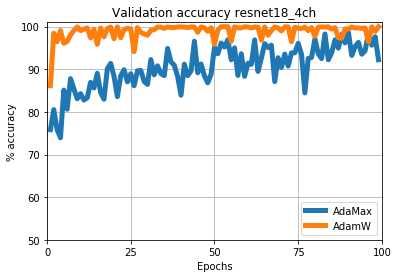

In [69]:
ymin = 50
ymax = 101
num = 100
lw = 5
x = np.arange(0,num,1) # Start at index position 1
plt.figure(figsize=(9, 6))
fig2 = plt.figure()
plt.plot(x[1:num],resnet18_4D_adamax[1:num], c='#1f77b4',markersize=1, linewidth=lw,markerfacecolor='#1f77b4',markeredgecolor='#1f77b4',markeredgewidth=1,label='AdaMax')
plt.plot(x[1:num],resnet18_4D_adamaw[1:num], c='#ff7f0e',markersize=1, linewidth=lw,markerfacecolor='#ff7f0e',markeredgecolor='#ff7f0e',markeredgewidth=1, label='AdamW')
# plt.plot(x[1:num],resnet18_5e6[1:num], c='#2ca02c', markersize=1, linewidth=lw,markerfacecolor='#2ca02c',markeredgecolor='#2ca02c',markeredgewidth=1, label='5e-6')
# plt.plot(x[1:num],resnet18_10e6[1:num], c='#d62728', markersize=1, linewidth=lw,markerfacecolor='#d62728',markeredgecolor='#d62728',markeredgewidth=1, label='10e-6')
# plt.plot(x[1:num],resnet18_100e6[1:num], c='#9467bd', markersize=1, linewidth=lw,markerfacecolor='#9467bd',markeredgecolor='#9467bd',markeredgewidth=1, label='100e-6')
# plt.plot(x[1:num],resnet18_500e6[1:num], c='#8c564b', markersize=1, linewidth=lw,markerfacecolor='#8c564b',markeredgecolor='#8c564b',markeredgewidth=2, label='500e-6')
plt.legend(loc='lower right')
axes = plt.gca() # Get the Current Axis, create one, if necessary
xmin = 0
xmax = 100
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
#  '-o'   '-X' '-P' '-D' '-^' '-*'
plt.title('Validation accuracy resnet18_4ch')
plt.xlabel('Epochs')
plt.ylabel('% accuracy')
plt.grid()
# plt.minorticks_on()
# plt.yticks(np.arange(70,80,90,100.01))
plt.xticks([0, 25, 50, 75, 100])
fig2.savefig('adamax_vs_adamw.pdf', format="pdf")
plt.show()

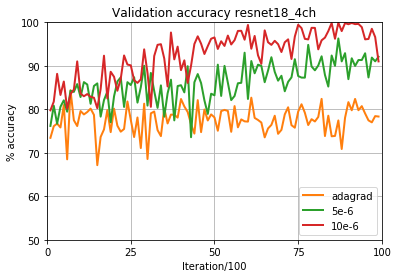

In [135]:
ymin = 50
ymax = 100
num = 100
lw = 2
x = np.arange(0,num,1) # Start at index position 1
plt.figure(figsize=(9, 6))
fig2 = plt.figure()
# plt.plot(x[1:num],resnet18_adadelta[1:num], c='#1f77b4',markersize=1, linewidth=lw,markerfacecolor='#1f77b4',markeredgecolor='#1f77b4',markeredgewidth=1,label='adadelta')
plt.plot(x[1:num],resnet18_adagrad[1:num], c='#ff7f0e',markersize=1, linewidth=lw,markerfacecolor='#ff7f0e',markeredgecolor='#ff7f0e',markeredgewidth=1, label='adagrad')
plt.plot(x[1:num],resnet18_5e6[1:num], c='#2ca02c', markersize=1, linewidth=lw,markerfacecolor='#2ca02c',markeredgecolor='#2ca02c',markeredgewidth=1, label='5e-6')
plt.plot(x[1:num],resnet18_10e6[1:num], c='#d62728', markersize=1, linewidth=lw,markerfacecolor='#d62728',markeredgecolor='#d62728',markeredgewidth=1, label='10e-6')
# plt.plot(x[1:num],resnet18_100e6[1:num], c='#9467bd', markersize=1, linewidth=lw,markerfacecolor='#9467bd',markeredgecolor='#9467bd',markeredgewidth=1, label='100e-6')
# plt.plot(x[1:num],resnet18_500e6[1:num], c='#8c564b', markersize=1, linewidth=lw,markerfacecolor='#8c564b',markeredgecolor='#8c564b',markeredgewidth=2, label='500e-6')
plt.legend(loc='lower right')
axes = plt.gca() # Get the Current Axis, create one, if necessary
xmin = 0
xmax = 100
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
#  '-o'   '-X' '-P' '-D' '-^' '-*'
plt.title('Validation accuracy resnet18_4ch')
plt.xlabel('Epochs')
plt.ylabel('% accuracy')
plt.grid()
# plt.minorticks_on()
# plt.yticks(np.arange(70,80,90,100.01))
plt.xticks([0, 25, 50, 75, 100])
fig2.savefig('winner.pdf', format="pdf")
plt.show()

## SCORE IQ DIRECTORIES

In [136]:
# model = load_model('ResNet50_v58_20210212_4D_100')

#### 1msps scoring

In [137]:
# load_net = 'ResNet50_v56_20210208_4D_20dB_autosave'
# load_net = 'ResNet50_v58_20210214_4D_10_autosave'
# load_net = 'ResNet50_v60_20210217_4D_300_autosave' # last scored
# load_net = 'ResNet50_v58_20210214_4D_150_autosave'
# load_net = 'ResNet50_v58_20210212_4D_100'
# load_net = 'ResNet50_v58_20210214_4D_300_autosave'
# load_net = 'ResNet18_v60_20210224_plot_4D_10dB_autosave'

In [75]:
final_data = np.zeros((10,10))
def pick(c,d):
    e = np.zeros((10,10))
    for j in range(10):
        if (d[j,c] >= .5):
            e[j,c] = 1
        else:
            e[j,np.argmax(d[j,:], axis=0)] = 1
    f = e.sum(axis=0)
    print('sum = ',f)
    return f

#### transform and re-save model data

In [76]:
final_data = np.zeros((10,10))

In [77]:
rf_model = 'ResNet152_4D_adamw'
# rf_model = 'ResNet18_20210304_4D_10dB_1e5'
# rf_model = 'ResNet18_20210304_4D_10dB_1e5'
PATH = path_save+rf_model
criterion = nn.CrossEntropyLoss()
lr= 1e-4
model = resnet152(4,12)
optimizer = optim.Adam(model.parameters(), lr=lr)
device = torch.device("cuda:0")
model.to(device)

ResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBottleNeckBlock(
            (blocks): Sequential(
              (0): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU()
              (2): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [78]:
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

#### save for scoring

In [79]:
rf_model = 'ResNet152_4D_adamw_scoring'
PATH = path_save+rf_model
torch.save(model.state_dict(), PATH)

In [80]:
load_net = 'ResNet152_4D_adamw_scoring'

inference file name =  UHF_clickndig_fob1_test1.sigmf-meta
inference file name =  UHF_clickndig_fob1_test10.sigmf-meta
inference file name =  UHF_clickndig_fob1_test2.sigmf-meta
inference file name =  UHF_clickndig_fob1_test3.sigmf-meta
inference file name =  UHF_clickndig_fob1_test4.sigmf-meta
inference file name =  UHF_clickndig_fob1_test5.sigmf-meta
inference file name =  UHF_clickndig_fob1_test6.sigmf-meta
inference file name =  UHF_clickndig_fob1_test7.sigmf-meta
inference file name =  UHF_clickndig_fob1_test8.sigmf-meta
inference file name =  UHF_clickndig_fob1_test9.sigmf-meta
iq_read_test file
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([5

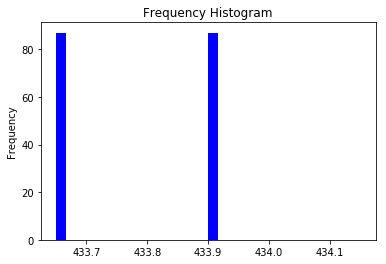

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.21
Vodeson Doorbell = 0.00%
clickndig = 0.79%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


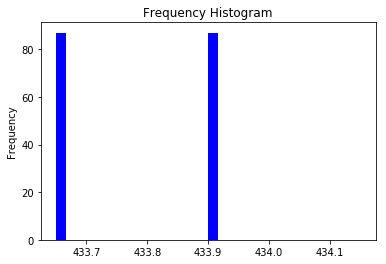

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.50
Vodeson Doorbell = 0.00%
clickndig = 0.50%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


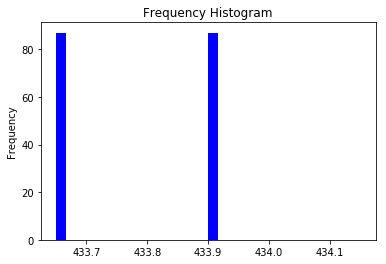

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.47
Vodeson Doorbell = 0.00%
clickndig = 0.53%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


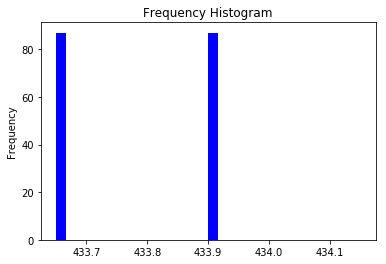

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.23
Vodeson Doorbell = 0.00%
clickndig = 0.77%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


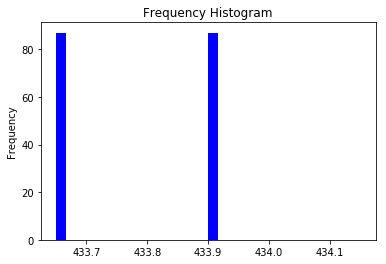

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.29
Vodeson Doorbell = 0.00%
clickndig = 0.71%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


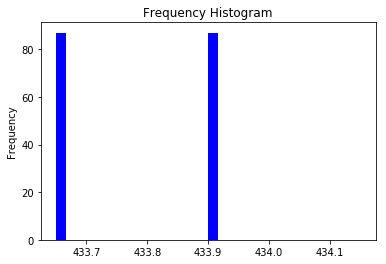

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.17
Vodeson Doorbell = 0.00%
clickndig = 0.83%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


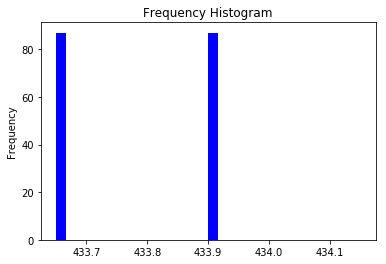

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.40
Vodeson Doorbell = 0.00%
clickndig = 0.60%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    401.36
std Freq =    114.05
length of inputs =  174


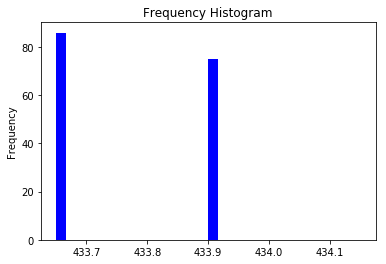

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.54
Vodeson Doorbell = 0.00%
clickndig = 0.46%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  13
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


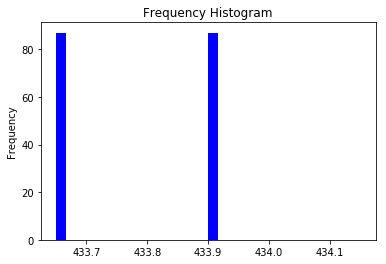

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.50
Vodeson Doorbell = 0.00%
clickndig = 0.50%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


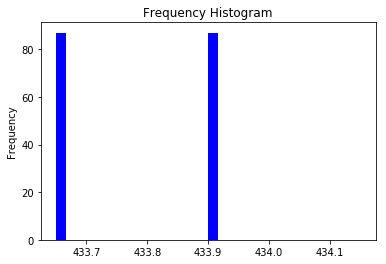

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.50
Vodeson Doorbell = 0.00%
clickndig = 0.50%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
sum =  [0. 0. 0. 1. 0. 9. 0. 0. 0. 0.]
final click [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 9. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [81]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps_click)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("click_1msps.csv", histogram, delimiter=",")
c = 5
final_data[c,:] = pick(c,histogram)
print('final click', final_data)

inference file name =  UHF_GD55_DMR_voice_test1.sigmf-meta
inference file name =  UHF_GD55_DMR_voice_test10.sigmf-meta
inference file name =  UHF_GD55_DMR_voice_test2.sigmf-meta
inference file name =  UHF_GD55_DMR_voice_test3.sigmf-meta
inference file name =  UHF_GD55_DMR_voice_test4.sigmf-meta
inference file name =  UHF_GD55_DMR_voice_test5.sigmf-meta
inference file name =  UHF_GD55_DMR_voice_test6.sigmf-meta
inference file name =  UHF_GD55_DMR_voice_test7.sigmf-meta
inference file name =  UHF_GD55_DMR_voice_test8.sigmf-meta
inference file name =  UHF_GD55_DMR_voice_test9.sigmf-meta
iq_read_test file
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([5

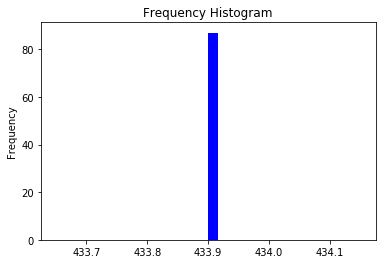

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 1.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


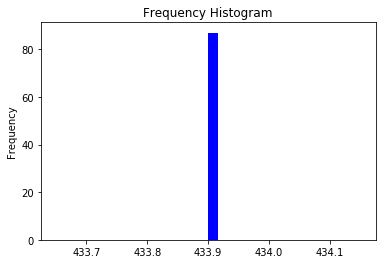

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 1.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


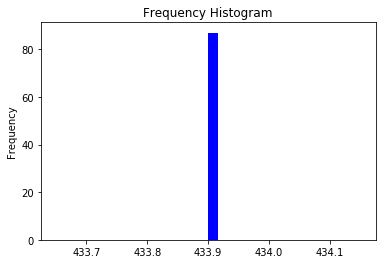

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 1.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


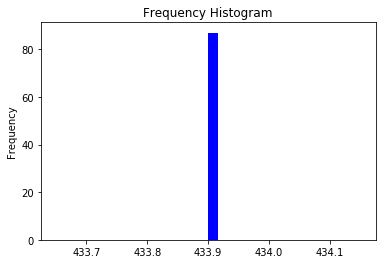

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 1.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


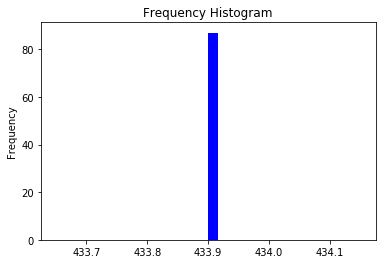

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 1.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


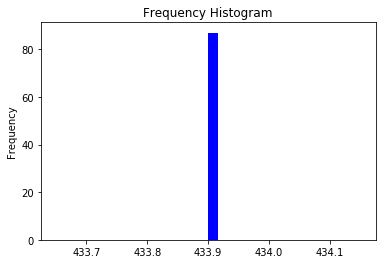

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 1.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


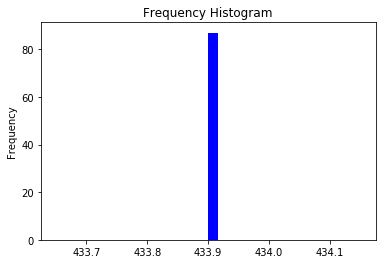

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 1.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


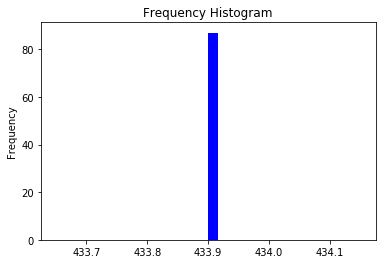

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 1.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


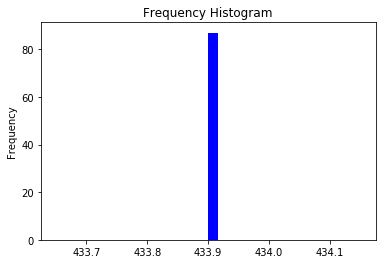

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 1.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


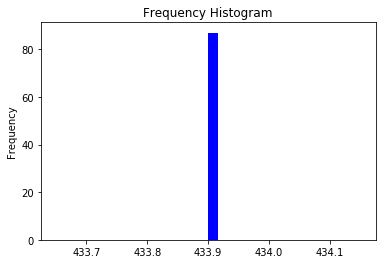

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 1.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
sum =  [ 0. 10.  0.  0.  0.  0.  0.  0.  0.  0.]


In [82]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps_gd55)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("gd55_1msps.csv", histogram, delimiter=",")
c = 1
final_data[c,:] = pick(c,histogram)

inference file name =  sw1_915_test1_on.sigmf-meta
inference file name =  sw1_915_test2_on.sigmf-meta
inference file name =  sw1_915_test3_on.sigmf-meta
inference file name =  sw1_915_test4_off.sigmf-meta
inference file name =  sw1_915_test5_off.sigmf-meta
inference file name =  sw1_915_test6_off.sigmf-meta
inference file name =  sw2_915_test1_on.sigmf-meta
inference file name =  sw2_915_test2_on.sigmf-meta
inference file name =  sw2_915_test3_on.sigmf-meta
inference file name =  sw2_915_test4_off.sigmf-meta
iq_read_test file
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Fina

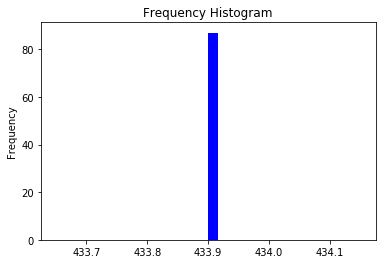

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 1.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


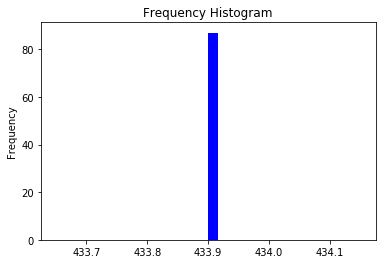

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 1.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


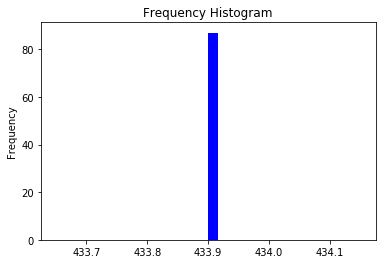

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 1.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


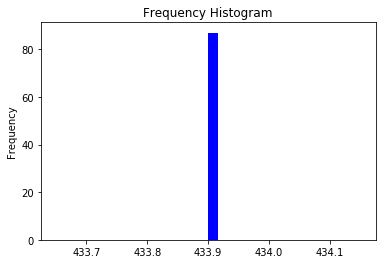

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 1.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


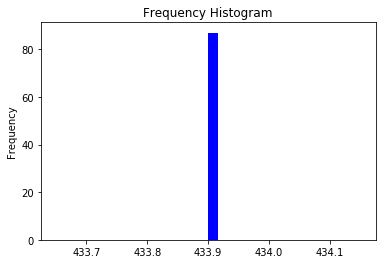

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 1.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


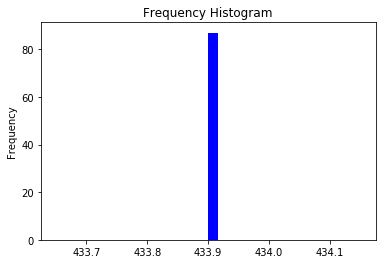

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 1.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


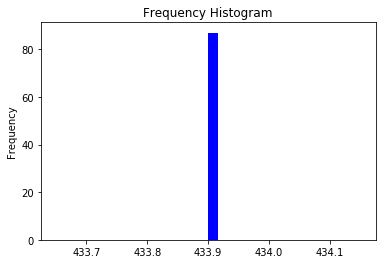

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 1.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


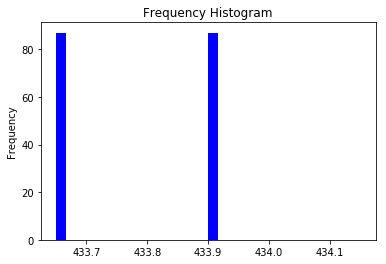

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.01%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.99%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


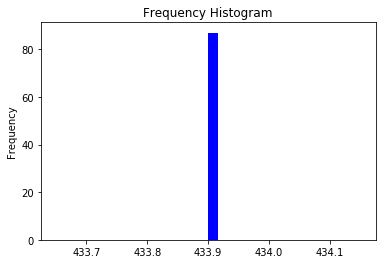

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 1.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    421.31
std Freq =     72.47
length of inputs =  174


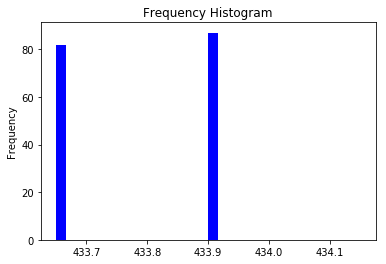

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.32%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.68%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  5
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
sum =  [ 0.  0.  0.  0.  0.  0.  0.  0. 10.  0.]


In [83]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps_light)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("light_1msps.csv", histogram, delimiter=",")
c = 8
final_data[c,:] = pick(c,histogram)

inference file name =  lora125_test1.sigmf-meta
inference file name =  lora125_test10.sigmf-meta
inference file name =  lora125_test2.sigmf-meta
inference file name =  lora125_test3.sigmf-meta
inference file name =  lora125_test4.sigmf-meta
inference file name =  lora125_test5.sigmf-meta
inference file name =  lora125_test6.sigmf-meta
inference file name =  lora125_test7.sigmf-meta
inference file name =  lora125_test8.sigmf-meta
inference file name =  lora125_test9.sigmf-meta
iq_read_test file
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.S

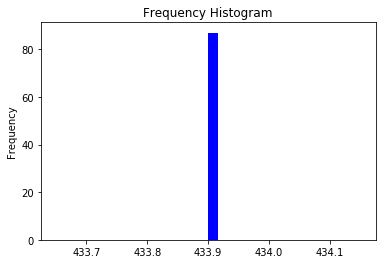

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 1.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


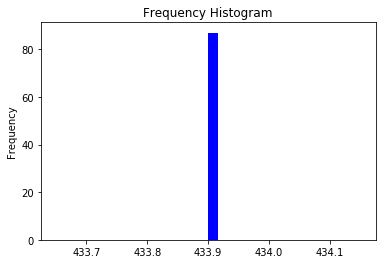

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 1.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


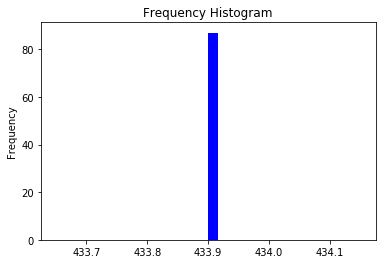

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 1.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


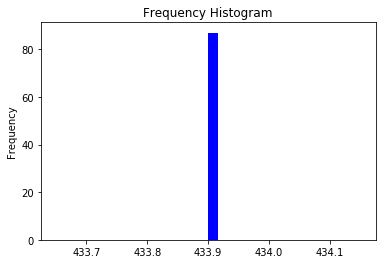

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 1.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


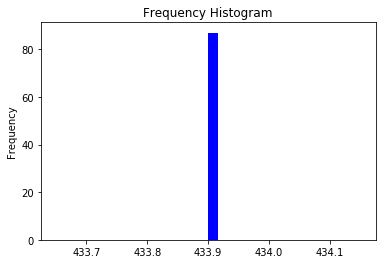

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 1.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


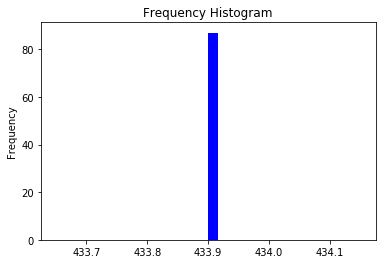

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 1.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


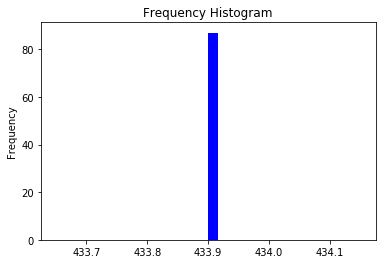

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 1.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


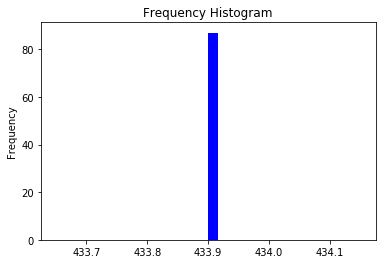

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 1.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


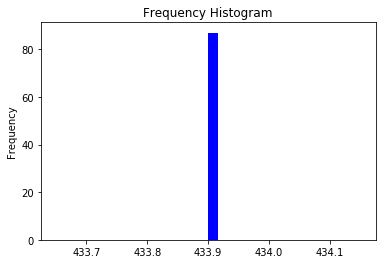

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.31%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.02%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.67%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


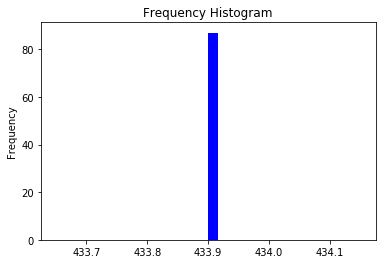

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.86%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.13%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
sum =  [8. 0. 0. 0. 0. 0. 0. 0. 2. 0.]


In [84]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps_lora125)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("lora125_1msps.csv", histogram, delimiter=",")
c = 0
final_data[c,:] = pick(c,histogram)

inference file name =  lora250_test1.sigmf-meta
inference file name =  lora250_test10.sigmf-meta
inference file name =  lora250_test2.sigmf-meta
inference file name =  lora250_test3.sigmf-meta
inference file name =  lora250_test4.sigmf-meta
inference file name =  lora250_test5.sigmf-meta
inference file name =  lora250_test6.sigmf-meta
inference file name =  lora250_test7.sigmf-meta
inference file name =  lora250_test8.sigmf-meta
inference file name =  lora250_test9.sigmf-meta
iq_read_test file
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.S

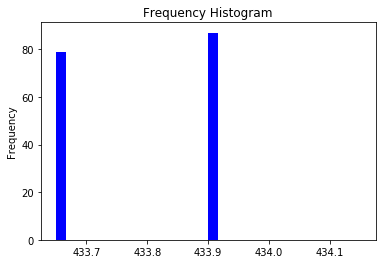

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 1.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  8
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    428.79
std Freq =     46.24
length of inputs =  174


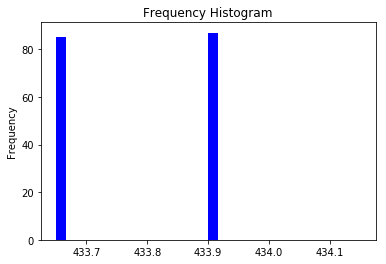

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 1.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    428.79
std Freq =     46.24
length of inputs =  174


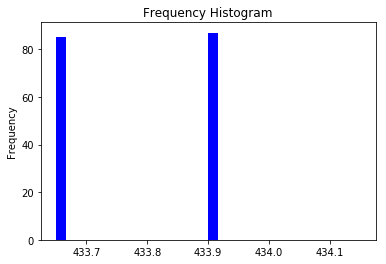

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 1.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    428.79
std Freq =     46.24
length of inputs =  174


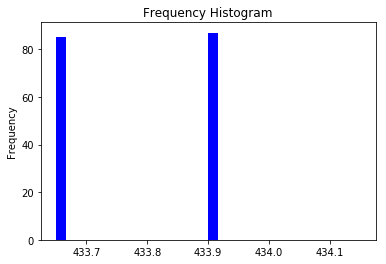

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 1.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    388.91
std Freq =    132.11
length of inputs =  174


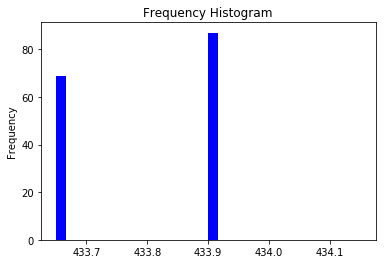

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 1.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  18
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    426.30
std Freq =     56.46
length of inputs =  174


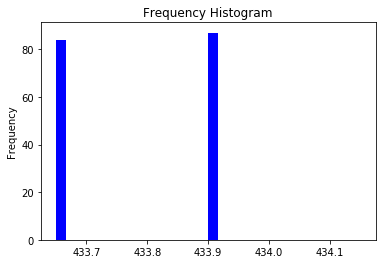

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 1.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  3
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    411.34
std Freq =     96.07
length of inputs =  174


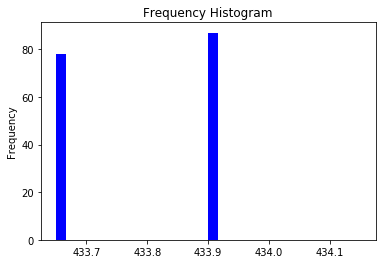

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 1.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  9
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    428.79
std Freq =     46.24
length of inputs =  174


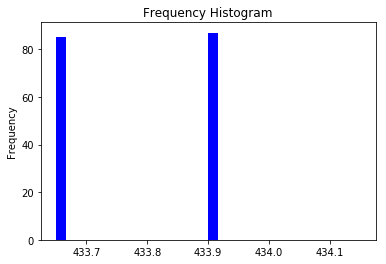

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 1.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    423.81
std Freq =     65.01
length of inputs =  174


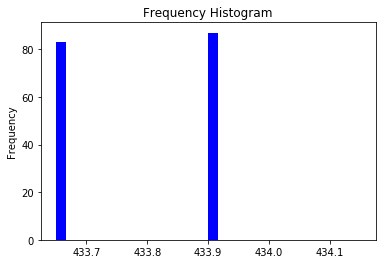

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 1.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  4
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    408.85
std Freq =    100.96
length of inputs =  174


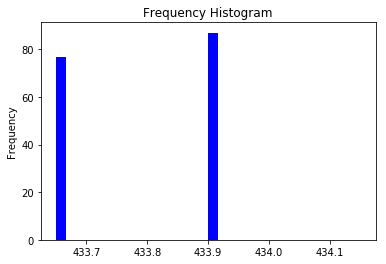

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 1.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  10
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
sum =  [ 0.  0.  0.  0.  0.  0.  0. 10.  0.  0.]


In [85]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps_lora250)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("lora250_1msps.csv", histogram, delimiter=",")
c = 7
final_data[c,:] = pick(c,histogram)

inference file name =  UHF_NFM_VX8_music2_test1.sigmf-meta
inference file name =  UHF_NFM_VX8_music2_test2.sigmf-meta
inference file name =  UHF_NFM_VX8_music2_test3.sigmf-meta
inference file name =  UHF_NFM_VX8_music2_test4.sigmf-meta
inference file name =  UHF_NFM_VX8_music2_test5.sigmf-meta
inference file name =  UHF_NFM_VX8_music2_test6.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test10.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test7.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test8.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test9.sigmf-meta
iq_read_test file
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 

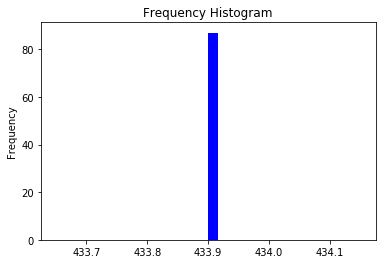

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.78%
NFM = 0.22%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


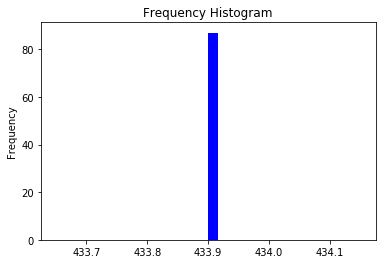

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 1.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


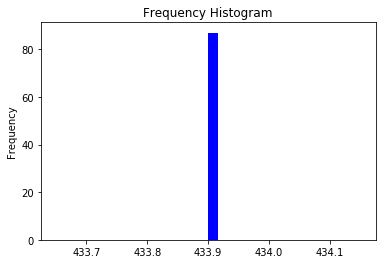

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 1.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


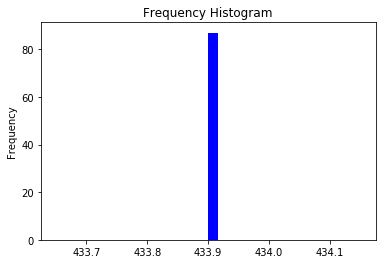

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 1.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


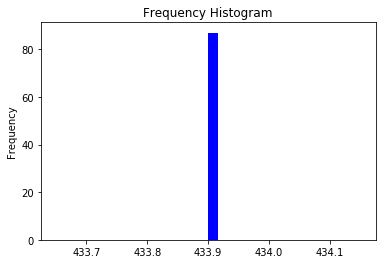

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 1.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


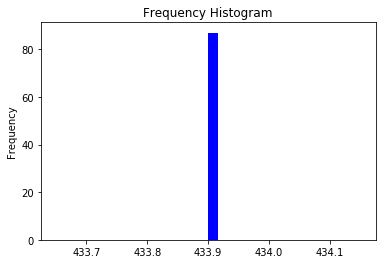

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 1.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


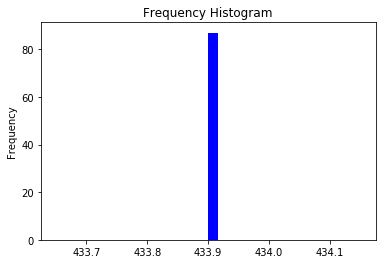

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.36%
NFM = 0.64%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


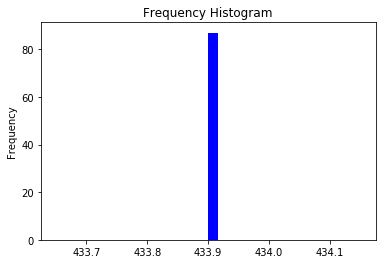

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 1.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


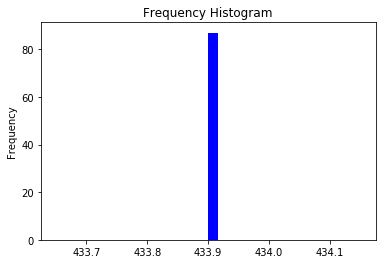

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.02%
NFM = 0.98%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


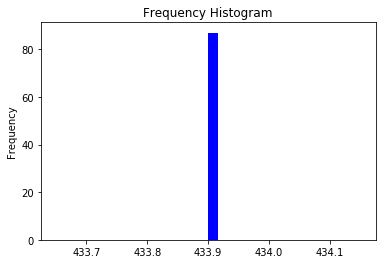

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.09%
NFM = 0.91%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
sum =  [0. 6. 4. 0. 0. 0. 0. 0. 0. 0.]


In [86]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps_nfm)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("nfm_1msps.csv", histogram, delimiter=",")
c = 2
final_data[c,:] = pick(c,histogram)

inference file name =  noise_test1.sigmf-meta
inference file name =  noise_test10.sigmf-meta
inference file name =  noise_test2.sigmf-meta
inference file name =  noise_test3.sigmf-meta
inference file name =  noise_test4.sigmf-meta
inference file name =  noise_test5.sigmf-meta
inference file name =  noise_test6.sigmf-meta
inference file name =  noise_test7.sigmf-meta
inference file name =  noise_test8.sigmf-meta
inference file name =  noise_test9.sigmf-meta
iq_read_test file
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])

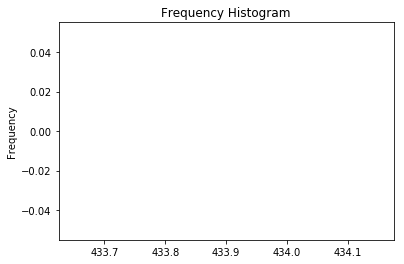

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  174
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174


/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:114: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:119: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.6/site-packages/ipykernel_launc

mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


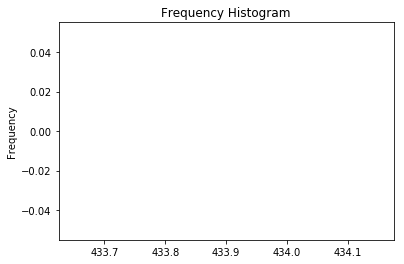

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  174
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


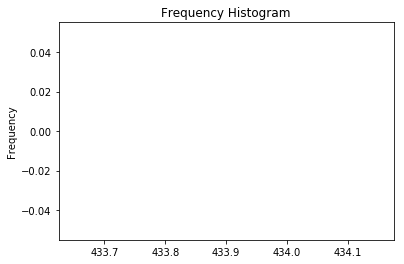

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  174
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


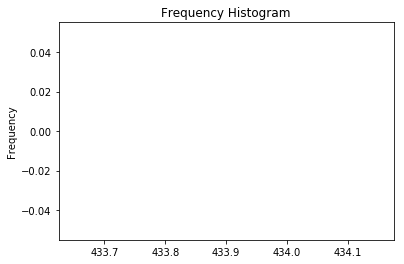

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  174
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


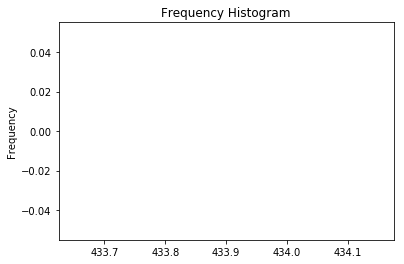

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  174
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


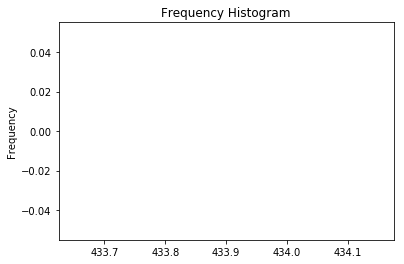

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  174
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


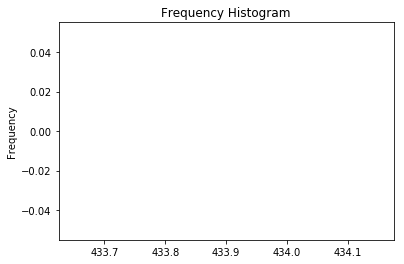

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  174
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


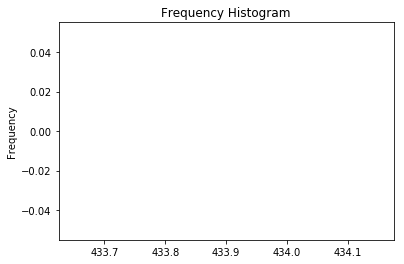

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  174
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


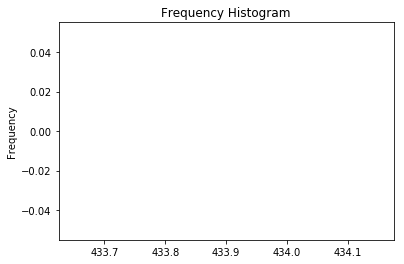

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  174
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


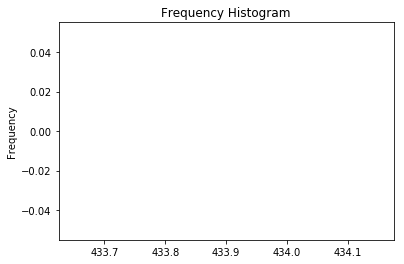

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  174
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************


In [87]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps_noise)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("noise_1msps.csv", histogram, delimiter=",")

inference file name =  UHF_sado_db1_test1.sigmf-meta
inference file name =  UHF_sado_db1_test10.sigmf-meta
inference file name =  UHF_sado_db1_test2.sigmf-meta
inference file name =  UHF_sado_db1_test3.sigmf-meta
inference file name =  UHF_sado_db1_test4.sigmf-meta
inference file name =  UHF_sado_db1_test5.sigmf-meta
inference file name =  UHF_sado_db1_test6.sigmf-meta
inference file name =  UHF_sado_db1_test7.sigmf-meta
inference file name =  UHF_sado_db1_test8.sigmf-meta
inference file name =  UHF_sado_db1_test9.sigmf-meta
iq_read_test file
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513

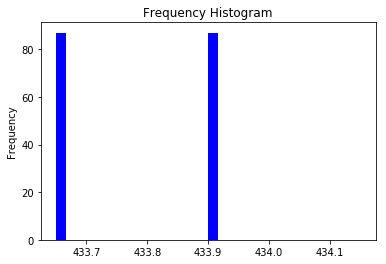

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


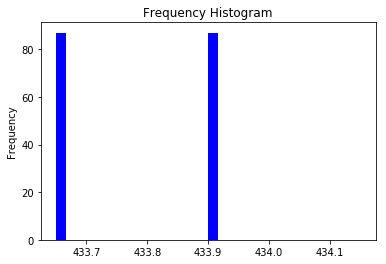

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.96%
LoRa 250 = 0.00%
light switch = 0.04%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


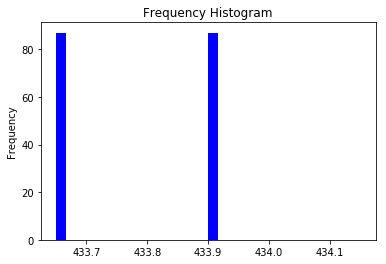

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.98%
LoRa 250 = 0.00%
light switch = 0.02%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


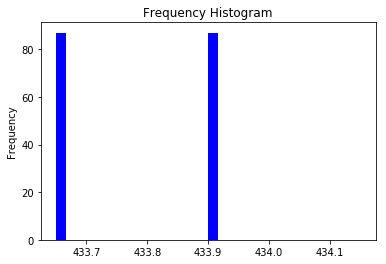

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


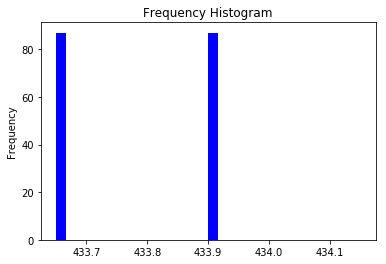

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


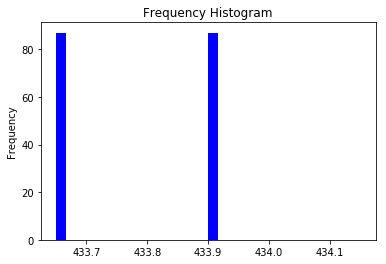

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.05%
NFM = 0.00%
TYT = 0.01
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.91%
LoRa 250 = 0.00%
light switch = 0.01%
YSF = 0.03%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


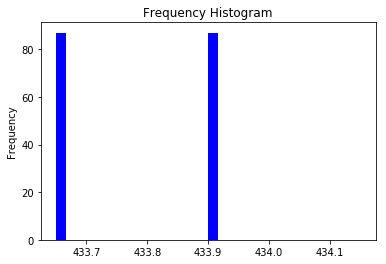

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


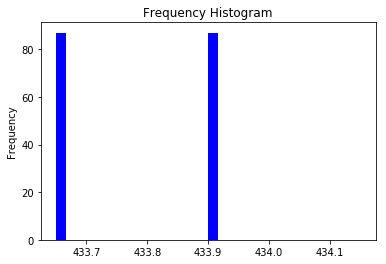

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


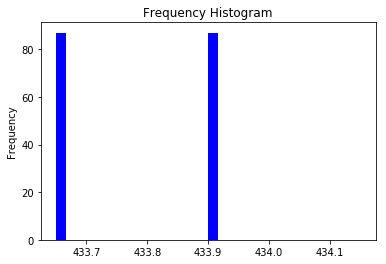

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


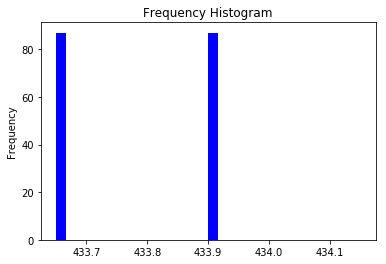

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
sum =  [ 0.  0.  0.  0.  0.  0. 10.  0.  0.  0.]


In [88]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps_sado)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("sado_1msps.csv", histogram, delimiter=",")
c = 6
final_data[c,:] = pick(c,histogram)

inference file name =  UHF_TYT_DMR_voice2_test1.sigmf-meta
inference file name =  UHF_TYT_DMR_voice2_test10.sigmf-meta
inference file name =  UHF_TYT_DMR_voice2_test2.sigmf-meta
inference file name =  UHF_TYT_DMR_voice2_test3.sigmf-meta
inference file name =  UHF_TYT_DMR_voice2_test4.sigmf-meta
inference file name =  UHF_TYT_DMR_voice2_test5.sigmf-meta
inference file name =  UHF_TYT_DMR_voice2_test6.sigmf-meta
inference file name =  UHF_TYT_DMR_voice2_test7.sigmf-meta
inference file name =  UHF_TYT_DMR_voice2_test8.sigmf-meta
inference file name =  UHF_TYT_DMR_voice2_test9.sigmf-meta
iq_read_test file
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([5

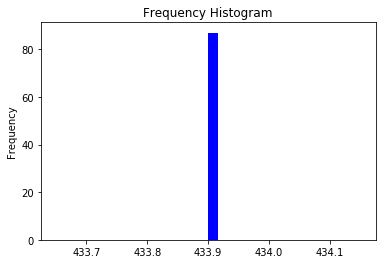

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =     72.32
std Freq =    161.70
length of inputs =  174


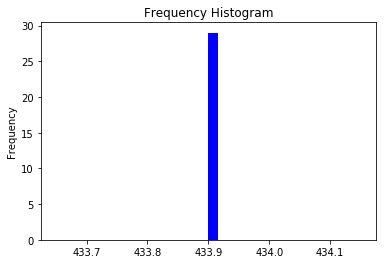

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  145
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


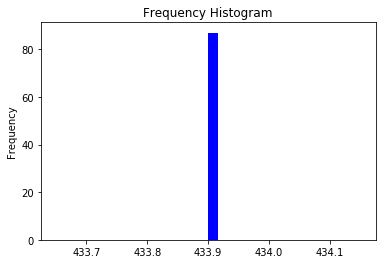

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


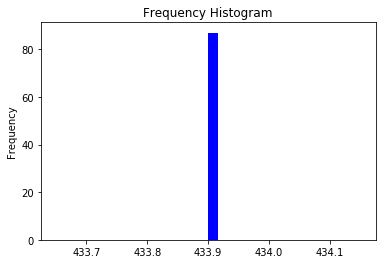

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


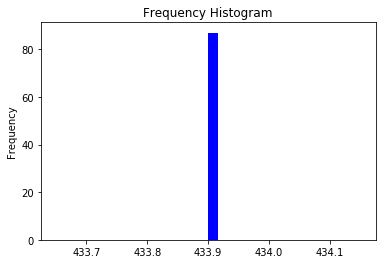

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


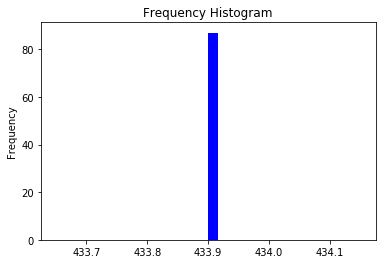

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


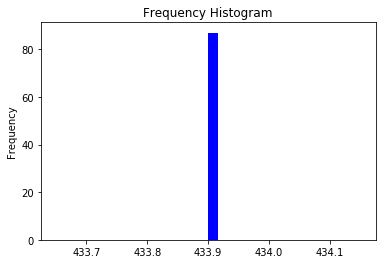

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    197.00
std Freq =    216.03
length of inputs =  174


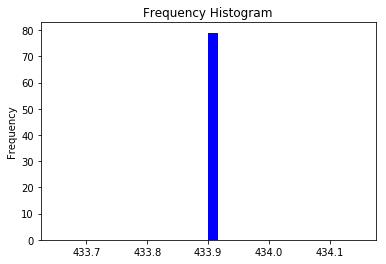

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  95
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


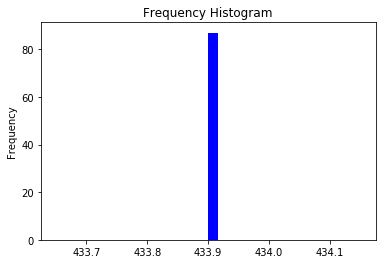

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


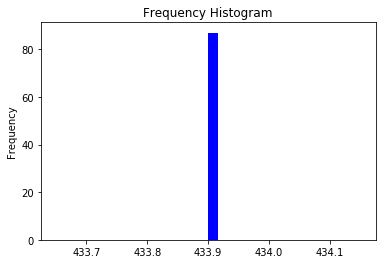

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
sum =  [ 0.  0.  0. 10.  0.  0.  0.  0.  0.  0.]


In [89]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps_tyt)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("tyt_1msps.csv", histogram, delimiter=",")
c = 3
final_data[c,:] = pick(c,histogram)

inference file name =  UHF_vodeson_test1.sigmf-meta
inference file name =  UHF_vodeson_test10.sigmf-meta
inference file name =  UHF_vodeson_test2.sigmf-meta
inference file name =  UHF_vodeson_test3.sigmf-meta
inference file name =  UHF_vodeson_test4.sigmf-meta
inference file name =  UHF_vodeson_test5.sigmf-meta
inference file name =  UHF_vodeson_test6.sigmf-meta
inference file name =  UHF_vodeson_test7.sigmf-meta
inference file name =  UHF_vodeson_test8.sigmf-meta
inference file name =  UHF_vodeson_test9.sigmf-meta
iq_read_test file
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4

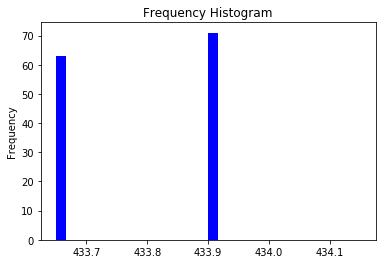

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.02
Vodeson Doorbell = 0.51%
clickndig = 0.39%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.08%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  40
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    286.69
std Freq =    205.35
length of inputs =  174


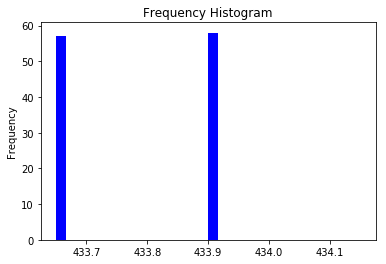

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.01
Vodeson Doorbell = 0.50%
clickndig = 0.36%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.14%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  59
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    326.58
std Freq =    187.11
length of inputs =  174


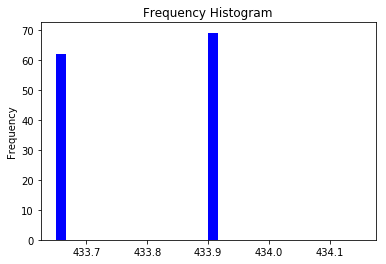

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.02
Vodeson Doorbell = 0.51%
clickndig = 0.36%
Sado doorbell = 0.00%
LoRa 250 = 0.01%
light switch = 0.11%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  43
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    329.08
std Freq =    185.62
length of inputs =  174


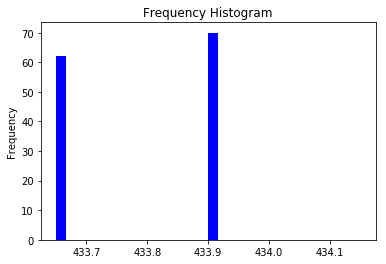

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.02
Vodeson Doorbell = 0.52%
clickndig = 0.31%
Sado doorbell = 0.00%
LoRa 250 = 0.04%
light switch = 0.11%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  42
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    334.06
std Freq =    182.52
length of inputs =  174


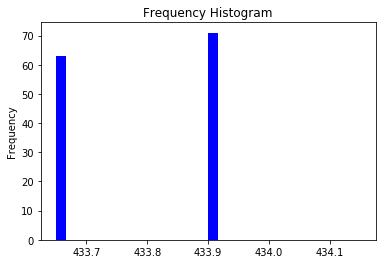

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.04
Vodeson Doorbell = 0.51%
clickndig = 0.20%
Sado doorbell = 0.00%
LoRa 250 = 0.14%
light switch = 0.10%
YSF = 0.01%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  40
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    319.10
std Freq =    191.30
length of inputs =  174


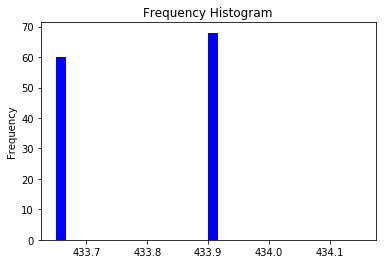

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.02
Vodeson Doorbell = 0.52%
clickndig = 0.36%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.09%
YSF = 0.01%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  46
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    341.54
std Freq =    177.49
length of inputs =  174


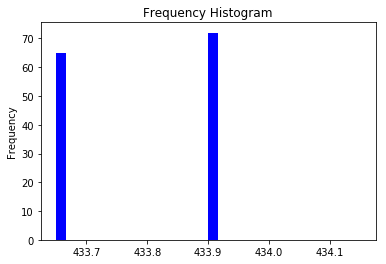

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.03
Vodeson Doorbell = 0.51%
clickndig = 0.36%
Sado doorbell = 0.00%
LoRa 250 = 0.02%
light switch = 0.07%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  37
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    234.34
std Freq =    216.19
length of inputs =  174


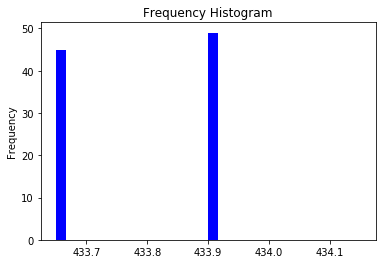

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.02
Vodeson Doorbell = 0.51%
clickndig = 0.34%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.12%
YSF = 0.01%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  80
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    296.66
std Freq =    201.68
length of inputs =  174


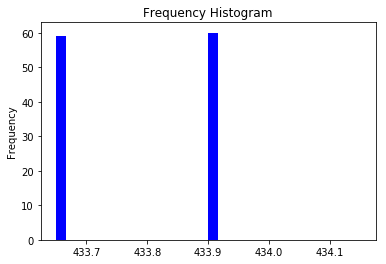

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.03
Vodeson Doorbell = 0.50%
clickndig = 0.26%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.22%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  55
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    266.75
std Freq =    211.08
length of inputs =  174


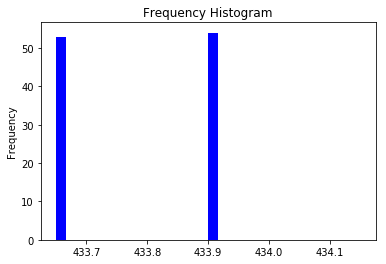

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.03
Vodeson Doorbell = 0.50%
clickndig = 0.35%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.13%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  67
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
sum =  [ 0.  0.  0.  0. 10.  0.  0.  0.  0.  0.]


In [90]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps_vod)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("vod_1msps.csv", histogram, delimiter=",")
c = 4
final_data[c,:] = pick(c,histogram)

inference file name =  UHF_YSF4_music2_test1.sigmf-meta
inference file name =  UHF_YSF4_music2_test2.sigmf-meta
inference file name =  UHF_YSF4_music2_test3.sigmf-meta
inference file name =  UHF_YSF4_music2_test4.sigmf-meta
inference file name =  UHF_YSF4_music2_test5.sigmf-meta
inference file name =  UHF_YSF4_music2_test6.sigmf-meta
inference file name =  UHF_YSF4_music2_test7.sigmf-meta
inference file name =  UHF_YSF4_voice_test10.sigmf-meta
inference file name =  UHF_YSF4_voice_test8.sigmf-meta
inference file name =  UHF_YSF4_voice_test9.sigmf-meta
iq_read_test file
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
Final gpu_test fil

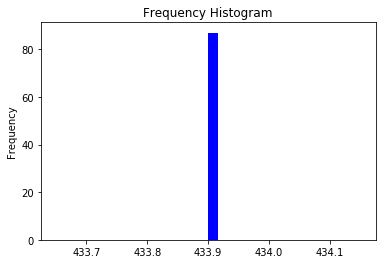

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


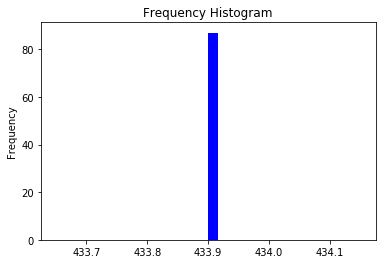

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


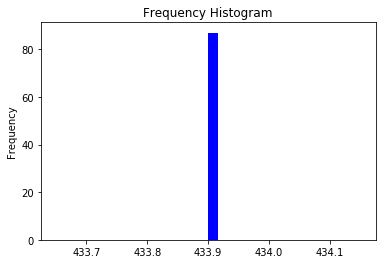

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


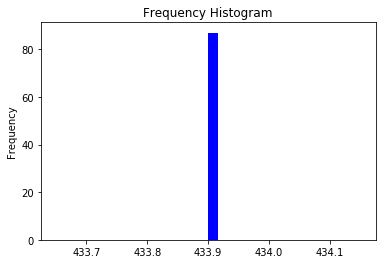

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


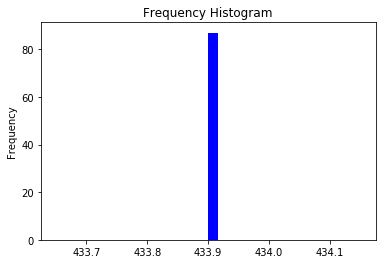

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.02%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.98%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


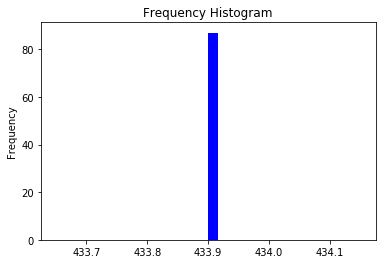

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


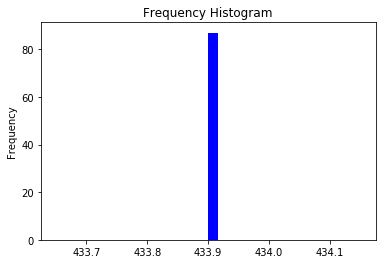

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.21%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.79%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


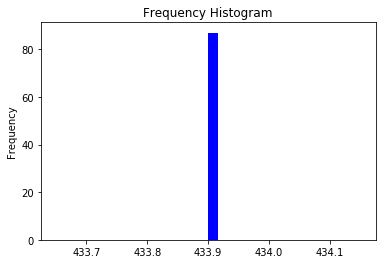

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


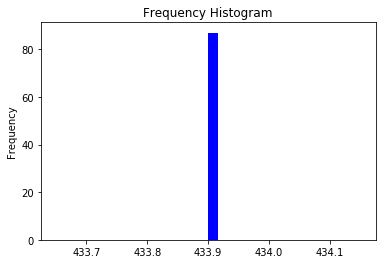

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
data shape =  (512, 19532, 4)
freq bins=  503
start_frequency =  433.65
patch total =  174
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


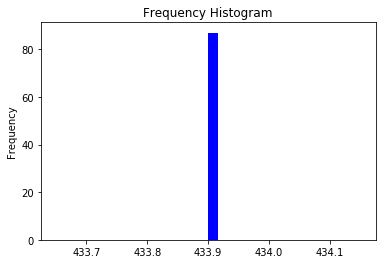

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
sum =  [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 10.]


In [91]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps_ysf)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("ysf_1msps.csv", histogram, delimiter=",")
c = 9
final_data[c,:] = pick(c,histogram)

In [92]:
final_data = final_data.astype(int)
final_data

array([[ 8,  0,  0,  0,  0,  0,  0,  0,  2,  0],
       [ 0, 10,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  6,  4,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 10,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  9,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 10,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 10,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 10,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 10]])

In [93]:
np.trace(final_data)

91

In [94]:
final_data = final_data.astype(int)
final_data

array([[ 8,  0,  0,  0,  0,  0,  0,  0,  2,  0],
       [ 0, 10,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  6,  4,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 10,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  9,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 10,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 10,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 10,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 10]])

In [95]:
np.trace(final_data)

91

In [ ]:
# final_data = final_data.astype(int)
# final_data

In [64]:
os.chdir(path_confuse)
np.savetxt("ResNet50_4D_adamw.csv", final_data, delimiter=",")
# np.save('vgg16_confuse', np.asarray(final_data))
# np.save('vgg16_confuse_2', final_data) 

#### 5msps scoring

inference file name =  UHF_clickndig_fob1_test1.sigmf-meta
iq_read_test file
Final gpu_test file Z shape = torch.Size([2561, 9766, 4])
imshow method


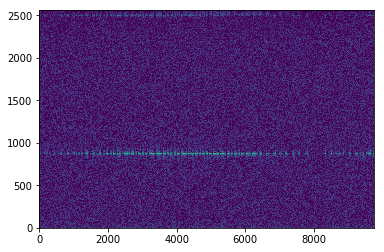

start_frequency =  433.0
patch total =  473
mean Freq =     39.43
std Freq =    124.67
length of inputs =  473


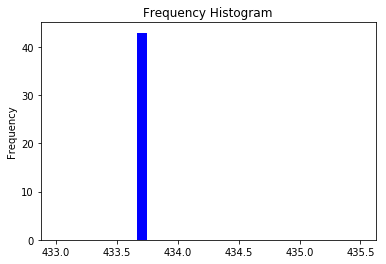

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  430
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************


In [112]:
msps = 5
center_freq_file = 433.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_5msps_click)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("click_5msps.csv", histogram, delimiter=",")

#### 25msps scoring

In [63]:
load_net = 'ResNet50_v60_20210227_4D_10dB_1e4lr_scoring'

In [64]:
final_data2 = np.zeros((10,10))

inference file name =  UHF_clickndig_fob1_test1.sigmf-meta
inference file name =  UHF_clickndig_fob1_test10.sigmf-meta
inference file name =  UHF_clickndig_fob1_test2.sigmf-meta
inference file name =  UHF_clickndig_fob1_test3.sigmf-meta
inference file name =  UHF_clickndig_fob1_test4.sigmf-meta
inference file name =  UHF_clickndig_fob1_test5.sigmf-meta
inference file name =  UHF_clickndig_fob1_test6.sigmf-meta
inference file name =  UHF_clickndig_fob1_test7.sigmf-meta
inference file name =  UHF_clickndig_fob1_test8.sigmf-meta
inference file name =  UHF_clickndig_fob1_test9.sigmf-meta
iq_read_test file
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.S

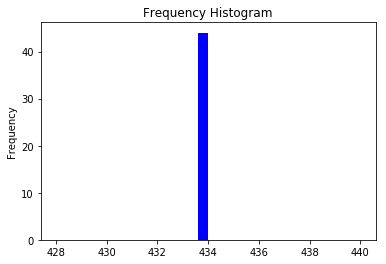

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2364
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      7.61
std Freq =     56.94
length of inputs =  2451


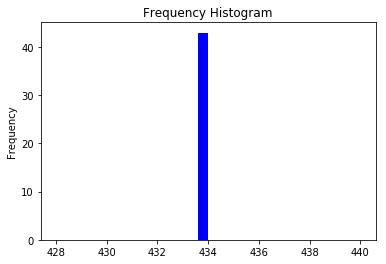

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      7.61
std Freq =     56.94
length of inputs =  2451


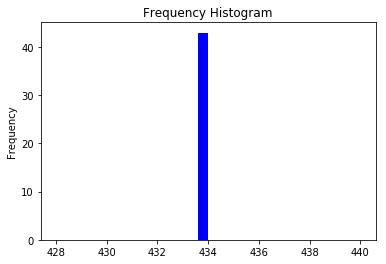

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      7.61
std Freq =     56.94
length of inputs =  2451


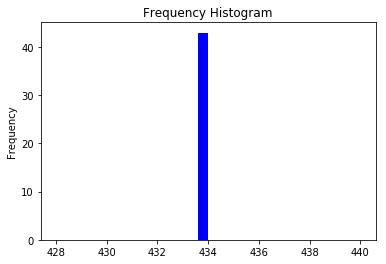

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      8.14
std Freq =     58.85
length of inputs =  2451


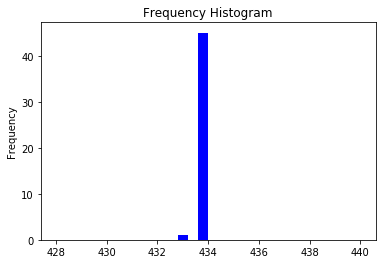

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.89
Vodeson Doorbell = 0.00%
clickndig = 0.11%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2362
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      9.20
std Freq =     62.50
length of inputs =  2451


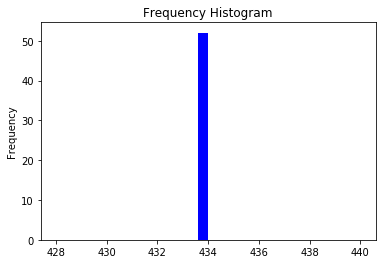

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.98
Vodeson Doorbell = 0.00%
clickndig = 0.02%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2356
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     13.10
std Freq =     74.23
length of inputs =  2451


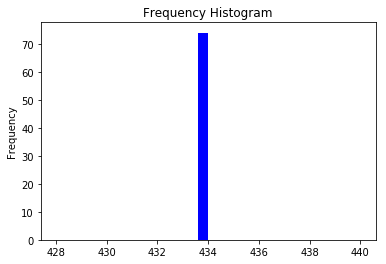

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.61
Vodeson Doorbell = 0.00%
clickndig = 0.39%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2334
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      7.78
std Freq =     57.58
length of inputs =  2451


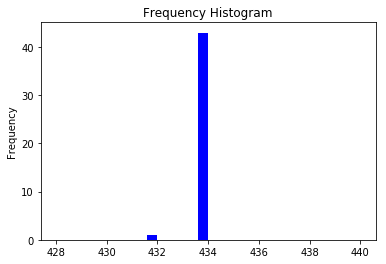

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2364
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      7.61
std Freq =     56.94
length of inputs =  2451


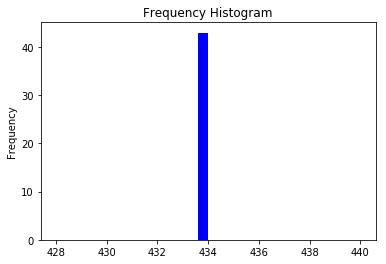

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      7.61
std Freq =     56.94
length of inputs =  2451


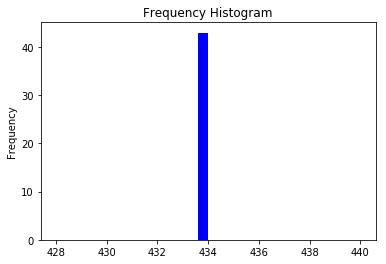

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
sum =  [ 0.  0.  0. 10.  0.  0.  0.  0.  0.  0.]


In [65]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path2_test_25msps_click)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("click_25msps.csv", histogram, delimiter=",")
c = 5
final_data2[c,:] = pick(c,histogram)

inference file name =  UHF_GD55_DMR_test1.sigmf-meta
inference file name =  UHF_GD55_DMR_test10.sigmf-meta
inference file name =  UHF_GD55_DMR_test2.sigmf-meta
inference file name =  UHF_GD55_DMR_test3.sigmf-meta
inference file name =  UHF_GD55_DMR_test4.sigmf-meta
inference file name =  UHF_GD55_DMR_test5.sigmf-meta
inference file name =  UHF_GD55_DMR_test6.sigmf-meta
inference file name =  UHF_GD55_DMR_test7.sigmf-meta
inference file name =  UHF_GD55_DMR_test8.sigmf-meta
inference file name =  UHF_GD55_DMR_test9.sigmf-meta
iq_read_test file
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Si

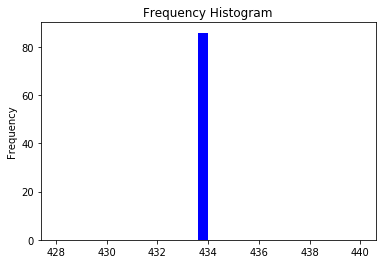

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.48%
TYT = 0.50
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.02%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     15.22
std Freq =     79.82
length of inputs =  2451


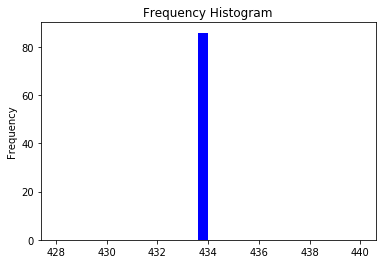

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.45%
TYT = 0.50
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.05%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     15.22
std Freq =     79.82
length of inputs =  2451


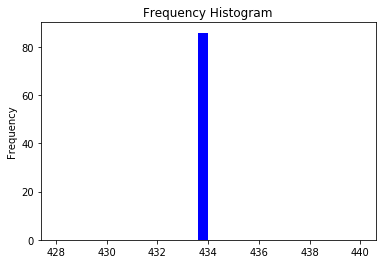

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.42%
TYT = 0.50
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.08%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     15.22
std Freq =     79.82
length of inputs =  2451


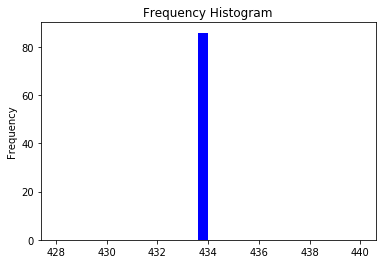

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.50%
TYT = 0.50
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     15.22
std Freq =     79.82
length of inputs =  2451


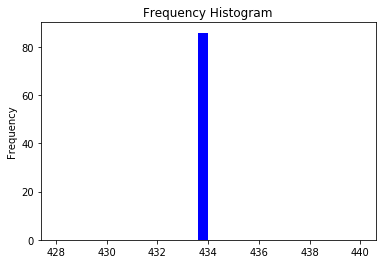

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.49%
TYT = 0.50
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.01%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     15.22
std Freq =     79.82
length of inputs =  2451


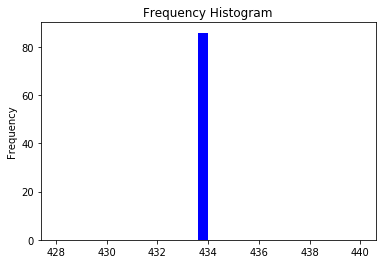

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.49%
TYT = 0.50
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.01%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     15.22
std Freq =     79.82
length of inputs =  2451


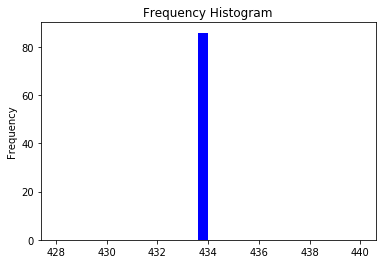

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.50%
TYT = 0.50
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     15.22
std Freq =     79.82
length of inputs =  2451


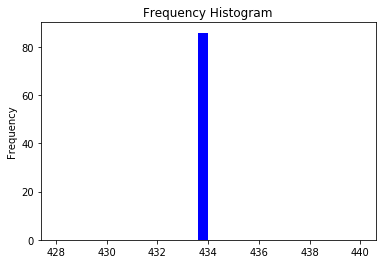

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.49%
TYT = 0.50
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.01%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     15.22
std Freq =     79.82
length of inputs =  2451


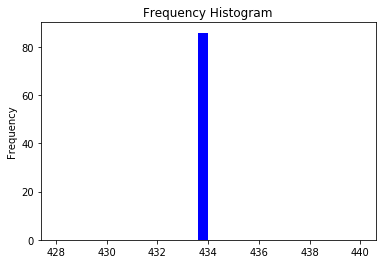

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.30%
TYT = 0.50
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.20%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     15.22
std Freq =     79.82
length of inputs =  2451


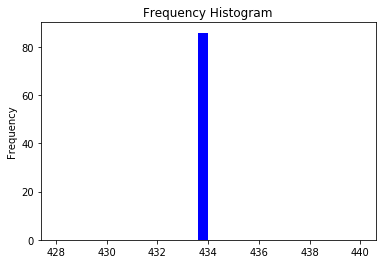

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.48%
TYT = 0.50
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.02%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
sum =  [0. 0. 2. 8. 0. 0. 0. 0. 0. 0.]


In [66]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path2_test_25msps_gd55)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("gd55_25msps.csv", histogram, delimiter=",")
c = 1
final_data2[c,:] = pick(c,histogram)

inference file name =  sw1_910_test1.sigmf-meta
inference file name =  sw1_910_test10.sigmf-meta
inference file name =  sw1_910_test2.sigmf-meta
inference file name =  sw1_910_test3.sigmf-meta
inference file name =  sw1_910_test4.sigmf-meta
inference file name =  sw1_910_test5.sigmf-meta
inference file name =  sw1_910_test6.sigmf-meta
inference file name =  sw1_910_test7.sigmf-meta
inference file name =  sw1_910_test8.sigmf-meta
inference file name =  sw1_910_test9.sigmf-meta
iq_read_test file
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape =

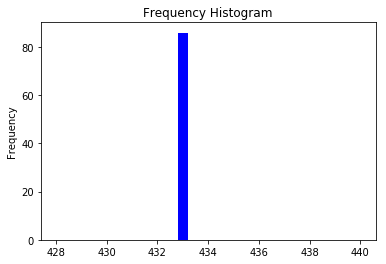

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.50
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.50%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     15.28
std Freq =     80.11
length of inputs =  2451


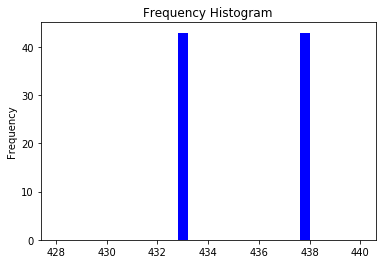

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.50%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.50%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     22.87
std Freq =     97.04
length of inputs =  2451


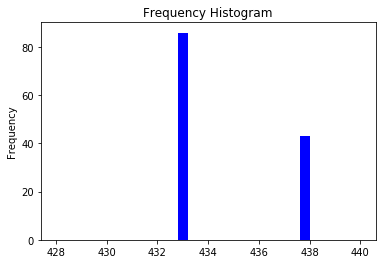

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.08%
NFM = 0.33%
TYT = 0.26
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.33%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2279
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     15.19
std Freq =     79.66
length of inputs =  2451


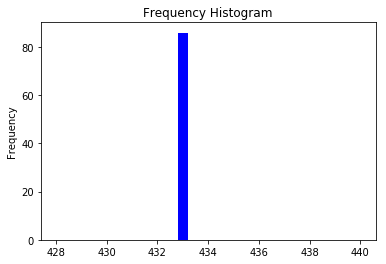

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.24%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.73%
YSF = 0.02%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     22.34
std Freq =     95.98
length of inputs =  2451


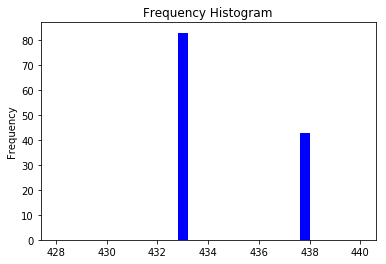

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.34%
TYT = 0.32
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.34%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2282
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     15.28
std Freq =     80.11
length of inputs =  2451


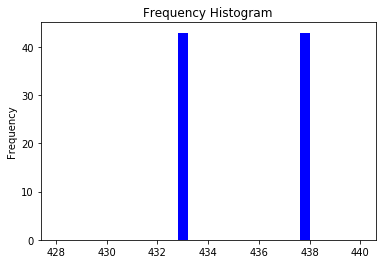

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.50%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.50%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     15.19
std Freq =     79.66
length of inputs =  2451


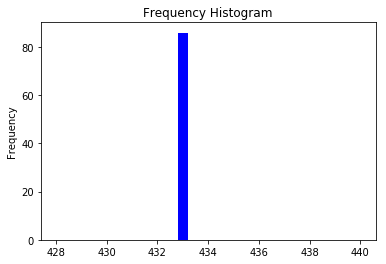

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.22%
NFM = 0.00%
TYT = 0.28
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.50%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     24.46
std Freq =    100.15
length of inputs =  2451


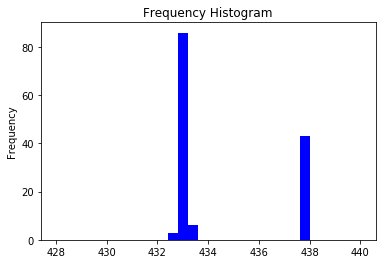

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.33%
NFM = 0.00%
TYT = 0.04
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.62%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2270
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     15.28
std Freq =     80.11
length of inputs =  2451


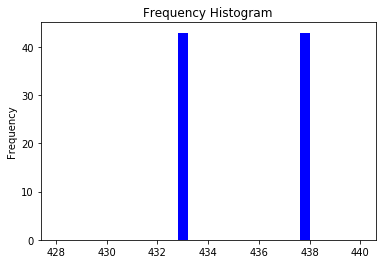

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.63%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.37%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     15.28
std Freq =     80.11
length of inputs =  2451


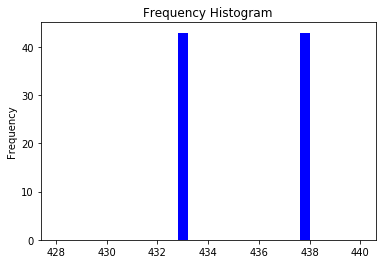

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.50%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.50%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
sum =  [0. 1. 2. 0. 0. 0. 0. 0. 7. 0.]


In [67]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path2_test_25msps_light)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("light_25msps.csv", histogram, delimiter=",")
c = 8
final_data2[c,:] = pick(c,histogram)

inference file name =  lora125_test1.sigmf-meta
inference file name =  lora125_test10.sigmf-meta
inference file name =  lora125_test2.sigmf-meta
inference file name =  lora125_test3.sigmf-meta
inference file name =  lora125_test4.sigmf-meta
inference file name =  lora125_test5.sigmf-meta
inference file name =  lora125_test6.sigmf-meta
inference file name =  lora125_test7.sigmf-meta
inference file name =  lora125_test8.sigmf-meta
inference file name =  lora125_test9.sigmf-meta
iq_read_test file
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape =

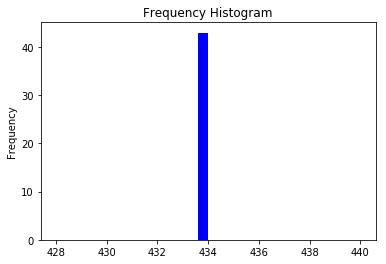

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.30%
LoRa 250 = 0.00%
light switch = 0.70%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      7.61
std Freq =     56.97
length of inputs =  2451


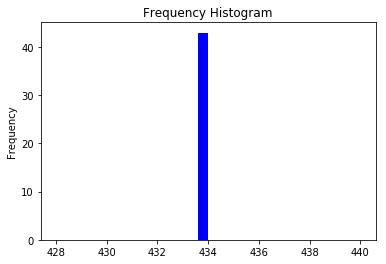

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 1.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      7.61
std Freq =     56.97
length of inputs =  2451


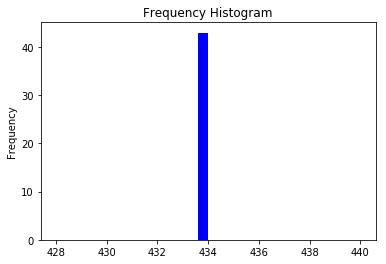

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.07%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.49%
LoRa 250 = 0.00%
light switch = 0.44%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      7.61
std Freq =     56.97
length of inputs =  2451


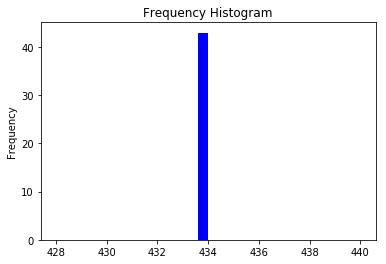

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 1.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      7.61
std Freq =     56.97
length of inputs =  2451


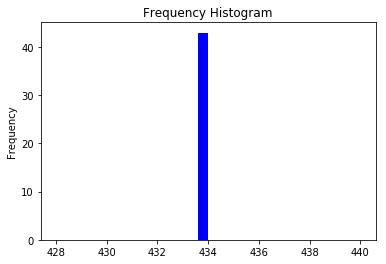

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 1.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      7.61
std Freq =     56.97
length of inputs =  2451


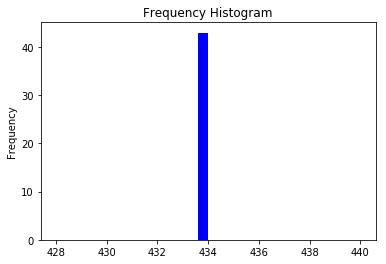

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.70%
LoRa 250 = 0.00%
light switch = 0.30%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      7.61
std Freq =     56.97
length of inputs =  2451


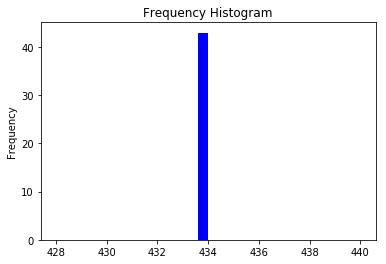

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.91%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.02%
LoRa 250 = 0.00%
light switch = 0.07%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      7.61
std Freq =     56.97
length of inputs =  2451


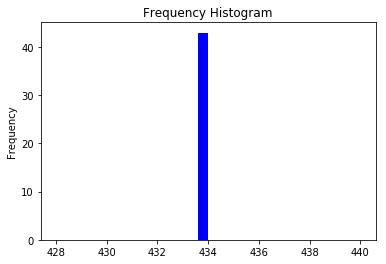

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 1.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      7.61
std Freq =     56.97
length of inputs =  2451


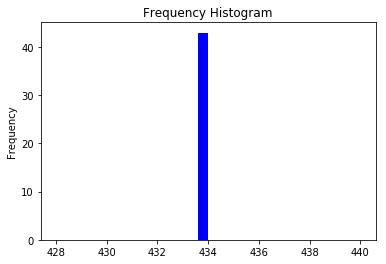

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 1.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      7.61
std Freq =     56.97
length of inputs =  2451


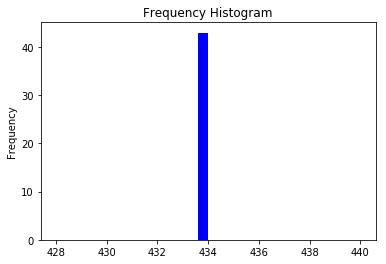

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 1.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
sum =  [7. 0. 0. 0. 0. 0. 2. 0. 1. 0.]


In [68]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path2_test_25msps_lora125)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("lora125_25msps.csv", histogram, delimiter=",")
c = 0
final_data2[c,:] = pick(c,histogram)

inference file name =  lora250_test1.sigmf-meta
inference file name =  lora250_test10.sigmf-meta
inference file name =  lora250_test2.sigmf-meta
inference file name =  lora250_test3.sigmf-meta
inference file name =  lora250_test4.sigmf-meta
inference file name =  lora250_test5.sigmf-meta
inference file name =  lora250_test6.sigmf-meta
inference file name =  lora250_test7.sigmf-meta
inference file name =  lora250_test8.sigmf-meta
inference file name =  lora250_test9.sigmf-meta
iq_read_test file
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape =

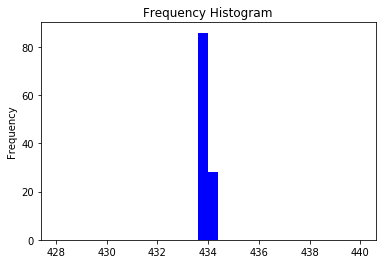

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.25
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.75%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2294
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     20.36
std Freq =     91.75
length of inputs =  2451


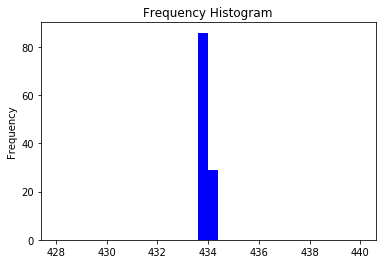

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.25
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.75%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2293
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     18.59
std Freq =     87.86
length of inputs =  2451


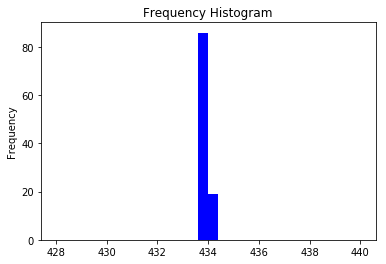

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.18
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.82%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2303
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     16.82
std Freq =     83.74
length of inputs =  2451


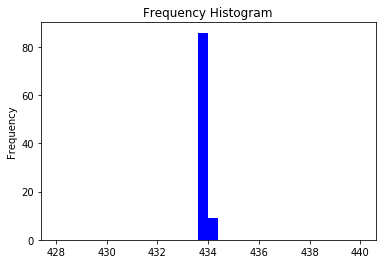

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.09
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.91%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2313
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     19.30
std Freq =     89.44
length of inputs =  2451


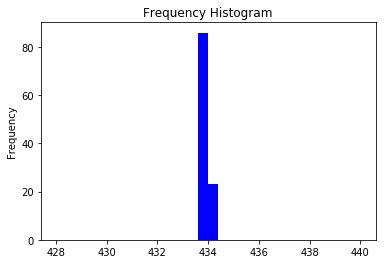

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.21
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.79%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2299
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     20.71
std Freq =     92.51
length of inputs =  2451


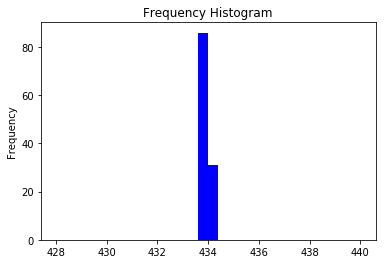

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.03%
TYT = 0.23
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.74%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2291
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     18.94
std Freq =     88.65
length of inputs =  2451


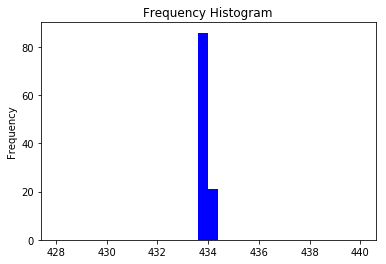

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.20
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.80%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2301
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     20.71
std Freq =     92.51
length of inputs =  2451


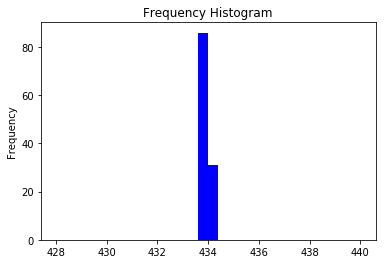

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.03%
TYT = 0.23
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.74%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2291
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     20.54
std Freq =     92.13
length of inputs =  2451


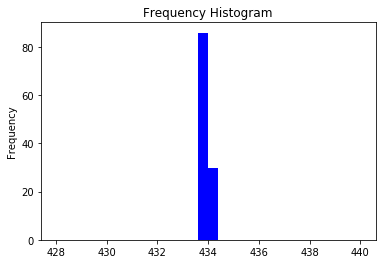

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.26
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.74%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2292
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     20.00
std Freq =     90.99
length of inputs =  2451


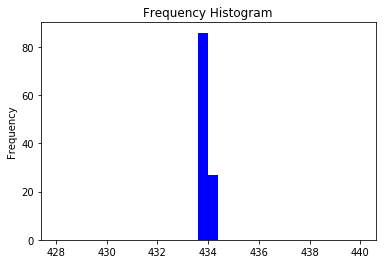

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.01%
TYT = 0.23
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.76%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2295
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
sum =  [ 0.  0.  0.  0.  0.  0.  0. 10.  0.  0.]


In [69]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path2_test_25msps_lora250)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("lora250_25msps.csv", histogram, delimiter=",")
c = 7
final_data2[c,:] = pick(c,histogram)

inference file name =  UHF_NFM_VX8_voice_test1.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test10.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test2.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test3.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test4.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test5.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test6.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test7.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test8.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test9.sigmf-meta
iq_read_test file
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801

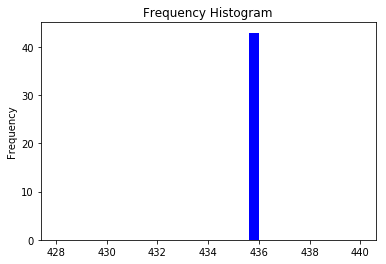

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.02%
NFM = 0.98%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


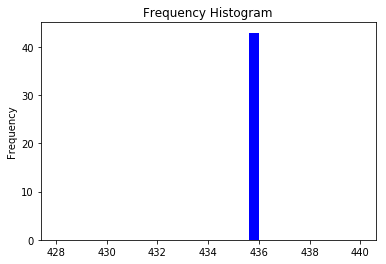

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.02%
NFM = 0.98%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


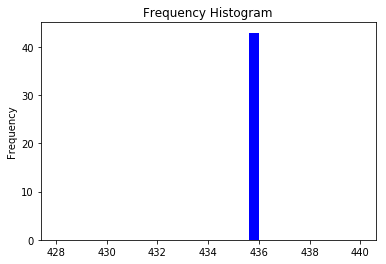

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.93%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.07%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


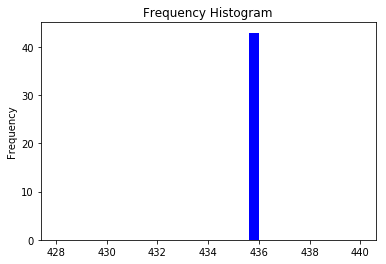

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.98%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.02%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


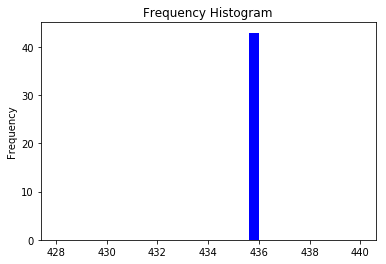

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.95%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.05%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


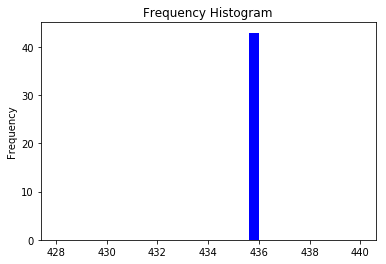

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.95%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.05%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


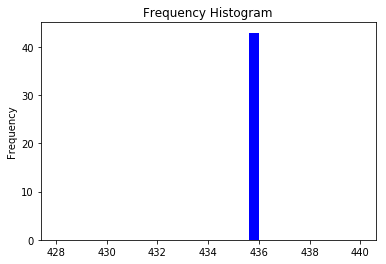

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 1.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


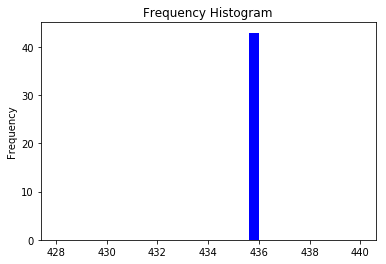

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 1.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


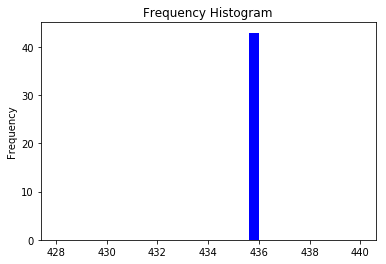

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 1.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


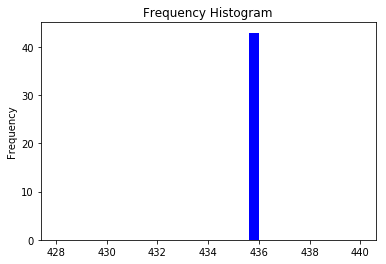

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 1.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
sum =  [ 0.  0. 10.  0.  0.  0.  0.  0.  0.  0.]


In [70]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path2_test_25msps_vx8)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("nfm_25msps.csv", histogram, delimiter=",")
c = 2
final_data2[c,:] = pick(c,histogram)

inference file name =  noise_test1.sigmf-meta
inference file name =  noise_test10.sigmf-meta
inference file name =  noise_test2.sigmf-meta
inference file name =  noise_test3.sigmf-meta
inference file name =  noise_test4.sigmf-meta
inference file name =  noise_test5.sigmf-meta
inference file name =  noise_test6.sigmf-meta
inference file name =  noise_test7.sigmf-meta
inference file name =  noise_test8.sigmf-meta
inference file name =  noise_test9.sigmf-meta
iq_read_test file
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 

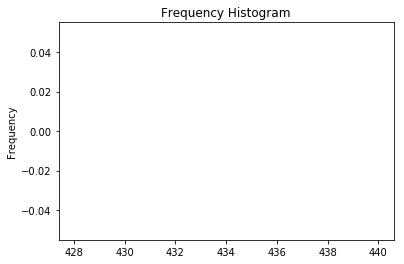

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2451
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451


/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in double_scalars
/home/david/.local/lib/python3.6/site-packages/ipykernel_launc

mean Freq =      0.00
std Freq =      0.00
length of inputs =  2451


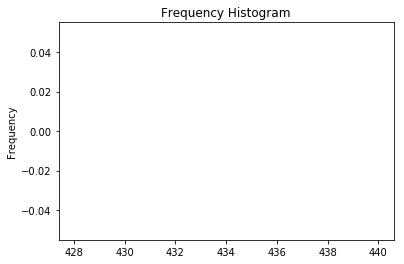

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2451
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      0.00
std Freq =      0.00
length of inputs =  2451


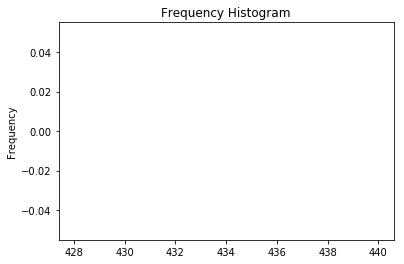

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2451
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      0.00
std Freq =      0.00
length of inputs =  2451


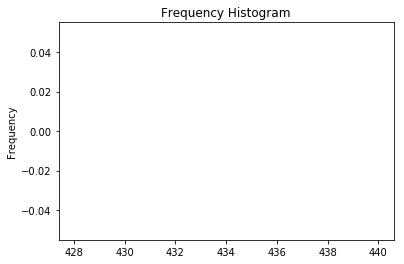

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2451
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      0.00
std Freq =      0.00
length of inputs =  2451


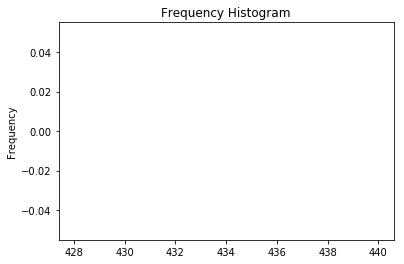

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2451
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      0.00
std Freq =      0.00
length of inputs =  2451


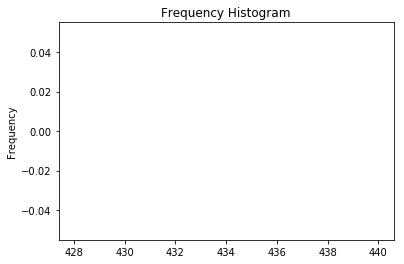

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2451
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      0.00
std Freq =      0.00
length of inputs =  2451


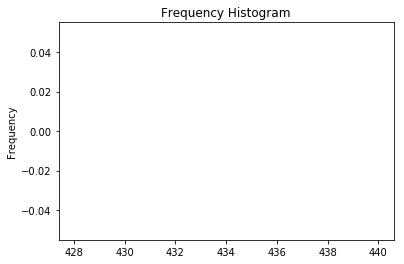

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2451
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      0.00
std Freq =      0.00
length of inputs =  2451


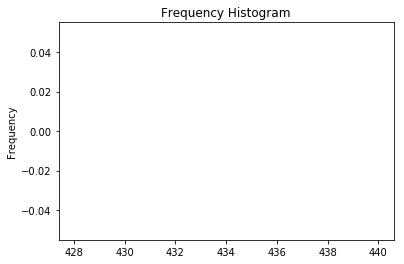

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2451
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      0.00
std Freq =      0.00
length of inputs =  2451


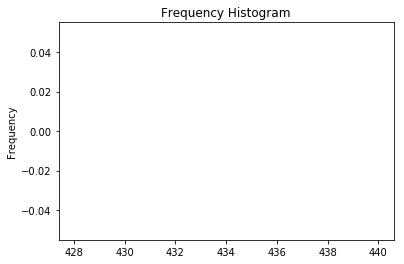

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2451
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      0.00
std Freq =      0.00
length of inputs =  2451


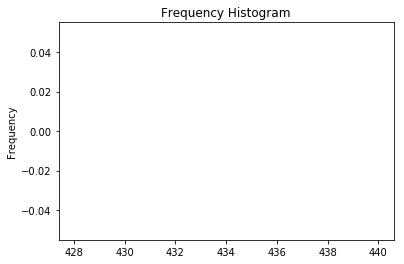

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2451
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************


In [71]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path2_test_25msps_noise)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("noise_25msps.csv", histogram, delimiter=",")

inference file name =  UHF_sado_db1_test1.sigmf-meta
inference file name =  UHF_sado_db1_test10.sigmf-meta
inference file name =  UHF_sado_db1_test2.sigmf-meta
inference file name =  UHF_sado_db1_test3.sigmf-meta
inference file name =  UHF_sado_db1_test4.sigmf-meta
inference file name =  UHF_sado_db1_test5.sigmf-meta
inference file name =  UHF_sado_db1_test6.sigmf-meta
inference file name =  UHF_sado_db1_test7.sigmf-meta
inference file name =  UHF_sado_db1_test8.sigmf-meta
inference file name =  UHF_sado_db1_test9.sigmf-meta
iq_read_test file
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Si

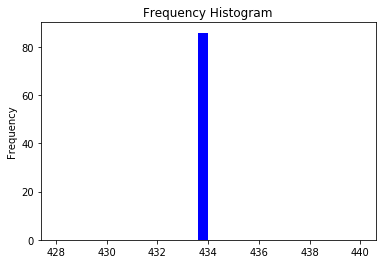

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     15.22
std Freq =     79.82
length of inputs =  2451


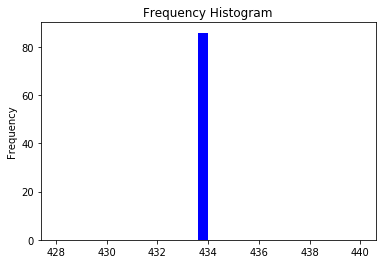

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     15.22
std Freq =     79.82
length of inputs =  2451


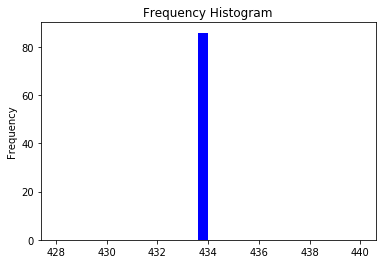

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     15.22
std Freq =     79.82
length of inputs =  2451


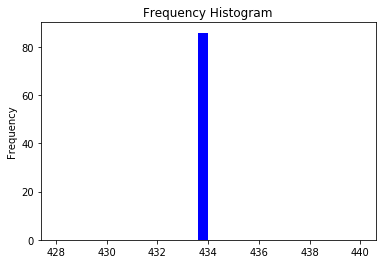

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     15.22
std Freq =     79.82
length of inputs =  2451


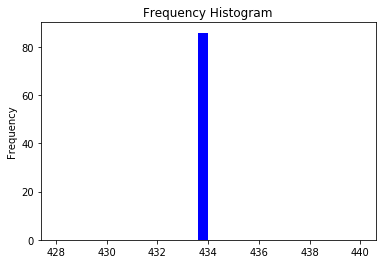

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.97%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.03%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     15.22
std Freq =     79.82
length of inputs =  2451


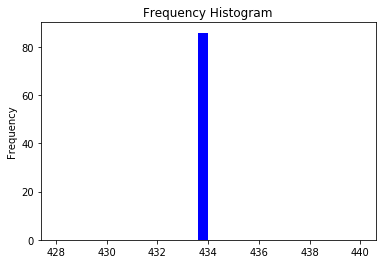

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.98%
LoRa 250 = 0.02%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     15.22
std Freq =     79.82
length of inputs =  2451


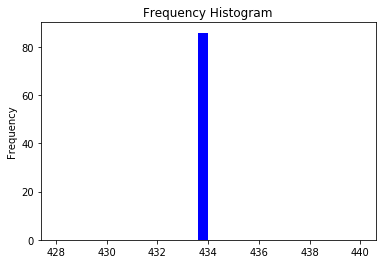

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     15.22
std Freq =     79.82
length of inputs =  2451


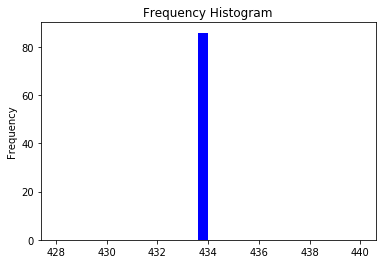

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.01%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.98%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.01%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     15.22
std Freq =     79.82
length of inputs =  2451


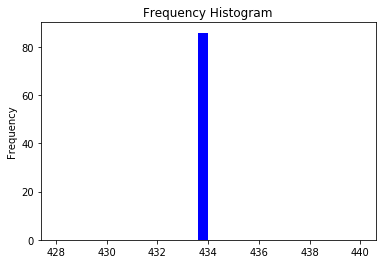

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     15.22
std Freq =     79.82
length of inputs =  2451


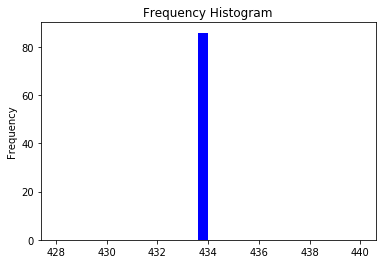

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
sum =  [ 0.  0.  0.  0.  0.  0. 10.  0.  0.  0.]


In [72]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path2_test_25msps_sado)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("sado_25msps.csv", histogram, delimiter=",")
c = 6
final_data2[c,:] = pick(c,histogram)

inference file name =  UHF_TYT_DMR_test1.sigmf-meta
inference file name =  UHF_TYT_DMR_test10.sigmf-meta
inference file name =  UHF_TYT_DMR_test2.sigmf-meta
inference file name =  UHF_TYT_DMR_test3.sigmf-meta
inference file name =  UHF_TYT_DMR_test4.sigmf-meta
inference file name =  UHF_TYT_DMR_test5.sigmf-meta
inference file name =  UHF_TYT_DMR_test6.sigmf-meta
inference file name =  UHF_TYT_DMR_test7.sigmf-meta
inference file name =  UHF_TYT_DMR_test8.sigmf-meta
inference file name =  UHF_TYT_DMR_test9.sigmf-meta
iq_read_test file
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801,

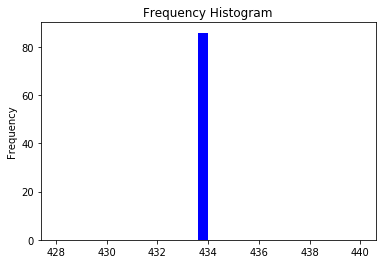

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.02%
TYT = 0.50
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.48%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     15.22
std Freq =     79.82
length of inputs =  2451


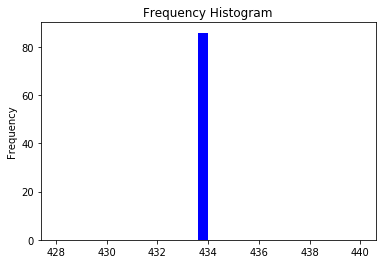

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.47%
TYT = 0.53
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     15.22
std Freq =     79.82
length of inputs =  2451


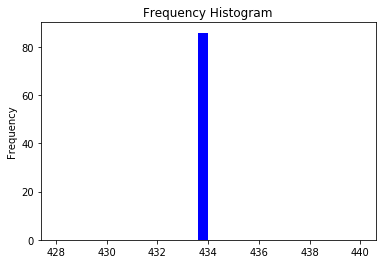

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.44%
TYT = 0.56
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     15.22
std Freq =     79.82
length of inputs =  2451


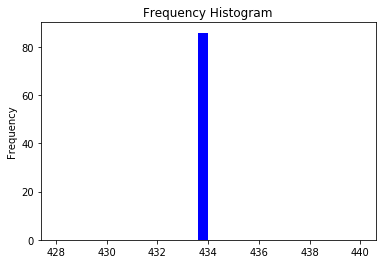

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.50
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.50%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     15.22
std Freq =     79.82
length of inputs =  2451


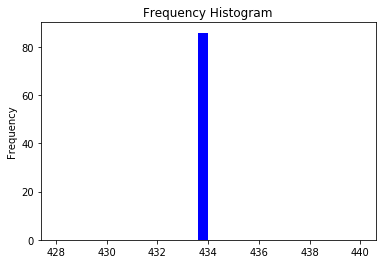

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.50
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.50%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     15.22
std Freq =     79.82
length of inputs =  2451


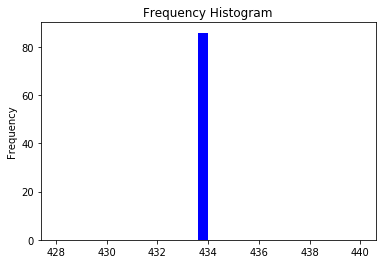

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.50
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.50%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     14.87
std Freq =     78.92
length of inputs =  2451


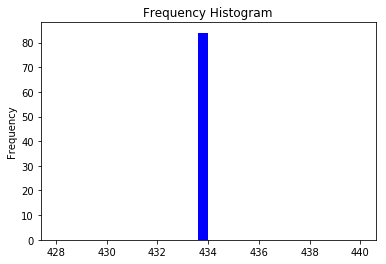

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.49
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.51%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2324
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     15.22
std Freq =     79.82
length of inputs =  2451


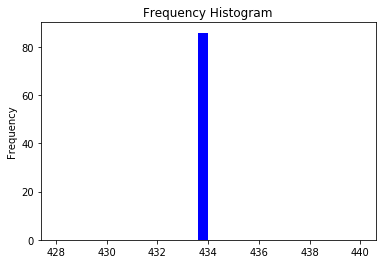

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.50
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.50%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     15.22
std Freq =     79.82
length of inputs =  2451


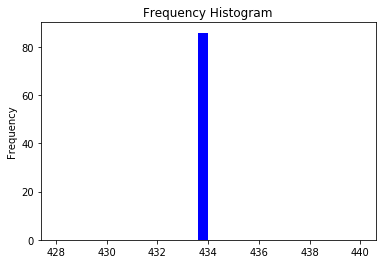

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.41%
TYT = 0.51
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.08%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     15.22
std Freq =     79.82
length of inputs =  2451


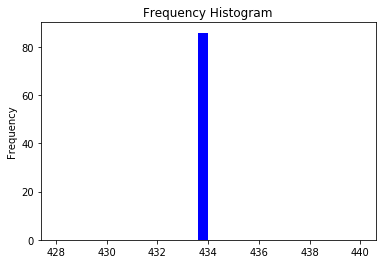

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.49%
TYT = 0.51
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
sum =  [0. 0. 0. 9. 0. 0. 0. 0. 0. 1.]


In [73]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path2_test_25msps_tyt)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("tyt_25msps.csv", histogram, delimiter=",")
c = 3
final_data2[c,:] = pick(c,histogram)

inference file name =  UHF_vodeson_test1.sigmf-meta
inference file name =  UHF_vodeson_test10.sigmf-meta
inference file name =  UHF_vodeson_test2.sigmf-meta
inference file name =  UHF_vodeson_test3.sigmf-meta
inference file name =  UHF_vodeson_test4.sigmf-meta
inference file name =  UHF_vodeson_test5.sigmf-meta
inference file name =  UHF_vodeson_test6.sigmf-meta
inference file name =  UHF_vodeson_test7.sigmf-meta
inference file name =  UHF_vodeson_test8.sigmf-meta
inference file name =  UHF_vodeson_test9.sigmf-meta
iq_read_test file
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801,

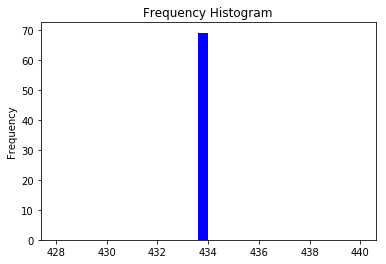

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.49%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.51%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2339
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     12.04
std Freq =     71.25
length of inputs =  2451


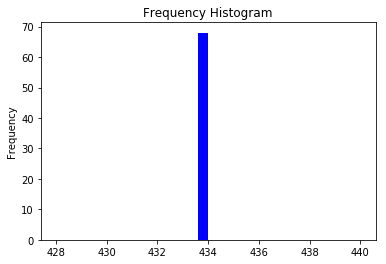

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.51%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.49%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2340
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     11.86
std Freq =     70.74
length of inputs =  2451


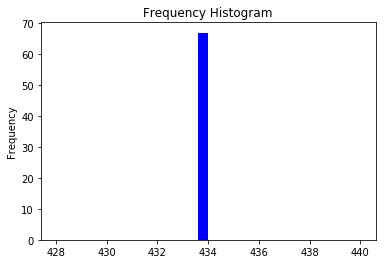

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.51%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.49%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2341
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     11.86
std Freq =     70.74
length of inputs =  2451


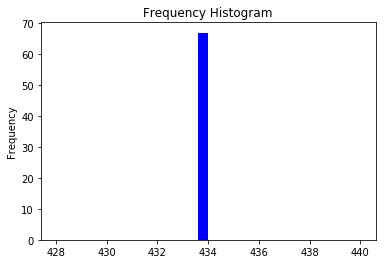

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.51%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.49%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2341
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     11.86
std Freq =     70.74
length of inputs =  2451


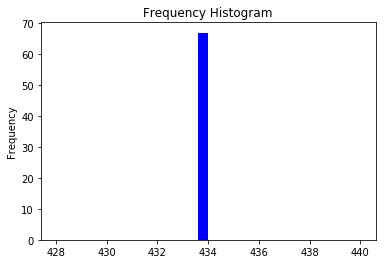

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.01
Vodeson Doorbell = 0.42%
clickndig = 0.07%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.49%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2341
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     11.68
std Freq =     70.22
length of inputs =  2451


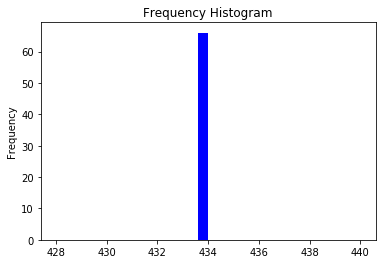

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.52%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.48%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2342
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     11.68
std Freq =     70.22
length of inputs =  2451


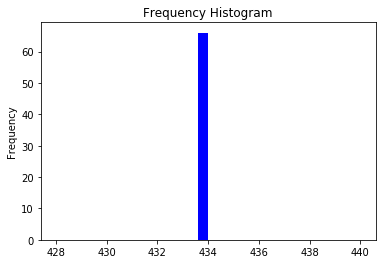

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.02
Vodeson Doorbell = 0.50%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.48%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2342
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     12.57
std Freq =     72.76
length of inputs =  2451


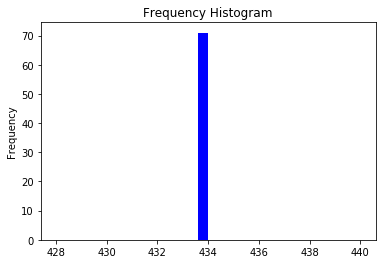

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.51%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.06%
YSF = 0.44%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2337
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     12.04
std Freq =     71.25
length of inputs =  2451


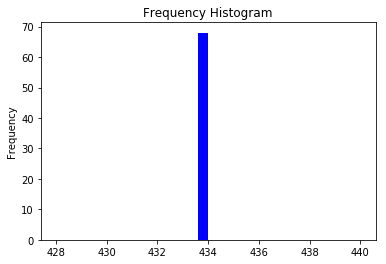

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.50%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.50%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2340
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =     11.86
std Freq =     70.74
length of inputs =  2451


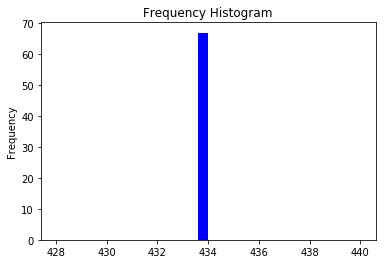

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.51%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.01%
YSF = 0.48%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2341
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
sum =  [0. 0. 0. 0. 8. 0. 0. 0. 0. 2.]


In [74]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path2_test_25msps_vod)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("vod_25msps.csv", histogram, delimiter=",")
c = 4
final_data2[c,:] = pick(c,histogram)

inference file name =  ysf_25msps_test1.sigmf-meta
inference file name =  ysf_25msps_test10.sigmf-meta
inference file name =  ysf_25msps_test2.sigmf-meta
inference file name =  ysf_25msps_test3.sigmf-meta
inference file name =  ysf_25msps_test4.sigmf-meta
inference file name =  ysf_25msps_test5.sigmf-meta
inference file name =  ysf_25msps_test6.sigmf-meta
inference file name =  ysf_25msps_test7.sigmf-meta
inference file name =  ysf_25msps_test8.sigmf-meta
inference file name =  ysf_25msps_test9.sigmf-meta
iq_read_test file
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])

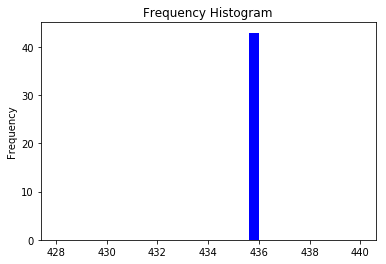

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.98%
NFM = 0.00%
TYT = 0.02
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


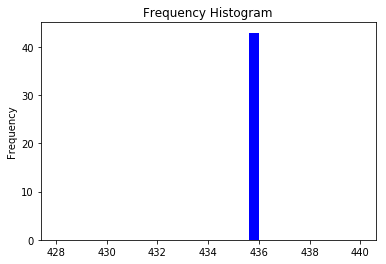

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 1.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


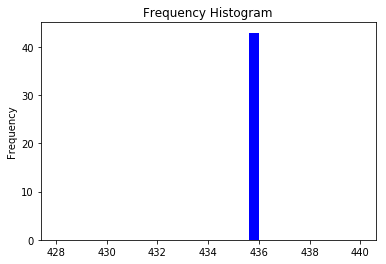

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 1.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


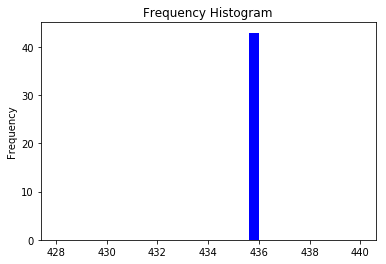

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 1.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


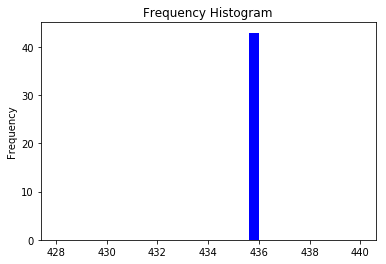

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 1.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


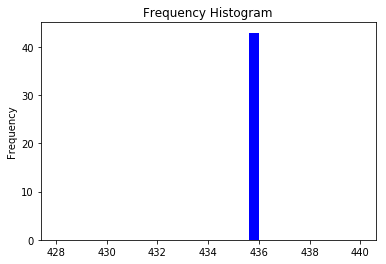

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.98%
NFM = 0.00%
TYT = 0.02
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


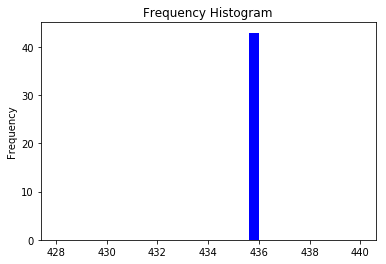

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 1.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


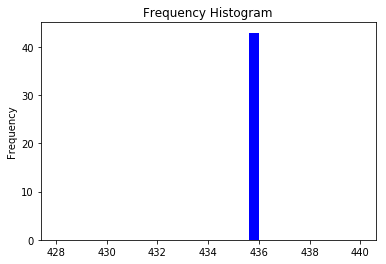

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 1.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


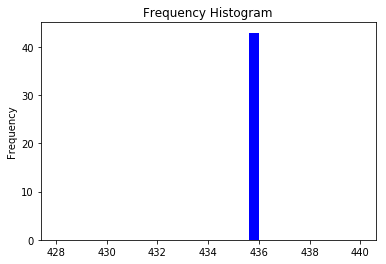

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 1.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
start_frequency =  428.0
patch total =  2451
mean Freq =      7.65
std Freq =     57.23
length of inputs =  2451


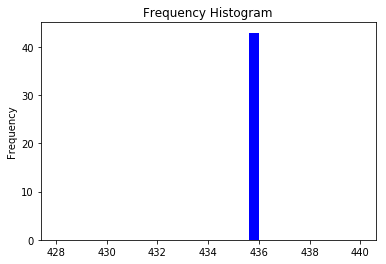

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.98%
NFM = 0.00%
TYT = 0.02
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2365
center fft matches =  43
TOTAL patch count =  2451
***************************** Finished *********************************
sum =  [ 0. 10.  0.  0.  0.  0.  0.  0.  0.  0.]


In [75]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path2_test_25msps_ysf)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("ysf_25msps.csv", histogram, delimiter=",")
c = 9
final_data2[c,:] = pick(c,histogram)

In [77]:
os.chdir(path_confuse)
np.savetxt("resnet50_4D_confuse_20210227_25msps_final.csv", final_data2, delimiter=",")

In [ ]:
torch.cuda.empty_cache()

#### Save and Load model data

In [42]:
# rf_model = 'ResNet50_v56_20210208_4D_20dB_autosave'

In [43]:
# PATH = path_save+rf_model

In [46]:
load_model()

#### save

In [145]:
# torch.save(model.state_dict(), PATH)

#### load

In [44]:
# device = torch.device("cuda:0")
# model = resnet50(4, 12)
# model.load_state_dict(torch.load(PATH))
# model.to(device)
# model.eval()

ResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBottleNeckBlock(
            (blocks): Sequential(
              (0): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU()
              (2): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [45]:
# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

In [46]:
# # Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])

In [47]:
# # SAVE MODEL
# os.chdir(path_save)
# torch.save({
#            'epoch': epoch,
#            'model_state_dict': model.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'loss': loss,
#            }, path_save+rf_model)

In [48]:
# # LOAD MODEL
# checkpoint = torch.load(path_save+rf_model, map_location=device)


# # STATUS
# checkpoint.keys()

# epoch = checkpoint['epoch']
# model_state_dict = checkpoint['model_state_dict']
# optimizer_state_dict = checkpoint['optimizer_state_dict']
# loss = checkpoint['loss']

# optimizer_state_dict.keys()

# optimizer_state_dict['param_groups']

# loss

# model.load_state_dict(model_state_dict)   

In [49]:
# loss

In [50]:
# optimizer_state_dict.keys()